---

# REACTOR SFR
__*Daniel Oliva Rodríguez*__

---

Para realizar una simulación en __*OpenMC*__ es necesario crear 3 archivos:
-  *materials.xml*: definición de los materiales presentes en el problema.
-  *geometry.xml*: definición de la geometría.
-  *settings.xml*: definición de la configuración de la simulación.

Siendo opcioneles la creación de otros 2:
-  *tallies.xml*: definición de los parámetros que se quieren medir durante la simulación.
-  *plots.xml*: definición de la representación gráfica de la geometría.

---

**ruta del archivo jupyter: _"raiz/simulaciones/sfr"_**

Ruta para guardar los archivos generados:

In [1]:
ruta = './build_01'

---

Importación de los módulos necesarios para la simulación:

In [2]:
import openmc
import openmc.deplete
import math
import os
import numpy as np
from matplotlib import pyplot
from PIL import Image as Image_ppm # Para convertir la imagen .ppm en .jpg
from IPython.display import Image, display # Para mostrar la imagen .jpg

In [3]:
os.mkdir(ruta)

In [4]:
os.mkdir(ruta + "/imagenes")

## Materiales

**Paso 1: Definición de Materiales** <br>
En este primer apartado __*materials*__ se definen los materiales que se van a emplear en la simulación (combustible, revestimiento, moderador, refrigerante, etc.).

Todas las definiciones de materiales tienen la misma morfología:
-  Se inicializa el material con __*openmc.Material(ID, "nombre")*__.
-  Se añade un elemento (con sus isótopos naturales) mediante __*add_element('símbolo', fracción, tipo_fracción)*__.
   -  La fracción puede ser atómica (*ao*) o en masa (*wo*). Si no se especifica, se toma por defecto *ao*.
   -  Se puede usar __*add_nuclide('símbolo', fracción, tipo_fracción)*__ para especificar un solo isótopo del elemento.
   -  En el caso del uranio, se puede establecer el enriquecimiento en U235 mediante un ajuste adicional: __*enrichment=4.2*__.
-  La densidad total del material se especifica mediante __*set_density('unidades', densidad)*__.

Definición de los materiales del **combustible**:<br>

Densidades:

In [5]:
densidad_uo2 = 0.955 * 10.97

In [6]:
densidad_puo2 = 0.955 * 10.97

In [7]:
densidad_npo2 = 11

In [8]:
densidad_amo2 = 11

In [9]:
densidad_cmo2 = 11

**Uranio**

In [10]:
fuel_uo2 = openmc.Material(name='Combustible UO2')
fuel_uo2.set_density('g/cm3', densidad_uo2)
fuel_uo2.add_element('O', 2.0)
fuel_uo2.add_element('U', 1.0)

**Plutonio**

In [11]:
fuel_puo2 = openmc.Material(name='Combustible PuO2')
fuel_puo2.set_density('g/cm3', densidad_puo2)
fuel_puo2.add_element('O', 2.0)
fuel_puo2.add_nuclide('Pu238', 0.025)
fuel_puo2.add_nuclide('Pu239', 0.55)
fuel_puo2.add_nuclide('Pu240', 0.25)
fuel_puo2.add_nuclide('Pu241', 0.1)
fuel_puo2.add_nuclide('Pu242', 0.075)

**Actinidos minoritarios**

In [12]:
fuel_npo2 = openmc.Material(name='Combustible Np237')
fuel_npo2.set_density('g/cm3', densidad_npo2)
fuel_npo2.add_element('O', 2.0)
fuel_npo2.add_nuclide('Np237', 1)

In [13]:
fuel_amo2 = openmc.Material(name='Combustible AmO2')
fuel_amo2.set_density('g/cm3', densidad_amo2)
fuel_amo2.add_element('O', 2.0)
fuel_amo2.add_nuclide('Am241', 0.7)
fuel_amo2.add_nuclide('Am243', 0.3)

In [14]:
fuel_cmo2 = openmc.Material(name='Combustible CmO2')
fuel_cmo2.set_density('g/cm3', densidad_cmo2)
fuel_cmo2.add_element('O', 2.0)
fuel_cmo2.add_nuclide('Cm244', 0.8)
fuel_cmo2.add_nuclide('Cm245', 0.2)

In [15]:
helium = openmc.Material(name='Helio')
helium.set_density('g/cm3', 0.1785)
helium.add_element('He', 1.0)

**Productos de fisión**

In [16]:
tc99 = openmc.Material(name='Tecnecio-99')
tc99.add_nuclide('Tc99', 1.0)
tc99.set_density('g/cm3', 11.46)
tc99.depletable = True

In [17]:
yi3 = openmc.Material(name='Yoduro de itrio')
yi3.add_nuclide('I129', 3.0)
yi3.add_element('Y', 1.0)
yi3.set_density('g/cm3', 4.58)
yi3.depletable = True

**Reflector**

In [18]:
acero_ht9 = openmc.Material(name='Acero HT9')
acero_ht9.add_element('Fe', 0.8555, 'wo')
acero_ht9.add_element('Cr', 0.12, 'wo')
acero_ht9.add_element('Mo', 0.01, 'wo')
acero_ht9.add_element('W', 0.005, 'wo')
acero_ht9.add_element('Ni', 0.005, 'wo')
acero_ht9.add_element('V', 0.0025, 'wo')
acero_ht9.add_element('C', 0.002, 'wo')
acero_ht9.set_density('g/cm3', 7.7)

**Revestimiento varilla**

In [19]:
al2o3 = openmc.Material(name='Al2O3')
al2o3.set_density('g/cm3', 4.0)
al2o3.add_element('O', 3.0)
al2o3.add_element('Al', 2.0)

In [20]:
clad = openmc.Material.mix_materials([acero_ht9, al2o3], [0.997, 0.003], 'wo')

**Revestimiento elemento combustible**

In [21]:
acero_em10 = openmc.Material(name='Acero EM10')
acero_em10.add_element('Fe', 0.87785, 'wo')
acero_em10.add_element('Cr', 0.088, 'wo')
acero_em10.add_element('Mo', 0.0109, 'wo')
acero_em10.add_element('Si', 0.0037, 'wo')
acero_em10.add_element('Mn', 0.0051, 'wo')
acero_em10.add_element('Ni', 0.0018, 'wo')
acero_em10.add_element('N', 0.0024, 'wo')
acero_em10.add_element('P', 0.00015, 'wo')
acero_em10.add_element('S', 0.0005, 'wo')
acero_em10.add_element('C', 0.0096, 'wo')
acero_em10.set_density('g/cm3', 7.76)

**Refrigerante**

In [22]:
sodium = openmc.Material(name='Sodio')
sodium.add_element('Na', 1.0)
sodium.set_density('g/cm3', 0.850)

**Vasija**

In [23]:
vasija = openmc.Material(name='Vasija')
vasija.add_element('Fe', 0.8555, 'wo')
vasija.add_element('Cr', 0.12, 'wo')
vasija.add_element('Mo', 0.01, 'wo')
vasija.add_element('W', 0.005, 'wo')
vasija.add_element('Ni', 0.005, 'wo')
vasija.add_element('V', 0.0025, 'wo')
vasija.add_element('C', 0.002, 'wo')
vasija.set_density('g/cm3', 7.7)

**Combustible reactor**

In [24]:
inner = openmc.Material.mix_materials(
    [fuel_uo2, fuel_puo2, fuel_npo2, fuel_amo2, fuel_cmo2],
    [0.77, 0.15, 0.03, 0.03, 0.02],
    'wo')

In [25]:
outer = openmc.Material.mix_materials(
    [fuel_uo2, fuel_puo2, fuel_npo2, fuel_amo2, fuel_cmo2],
    [0.72, 0.20, 0.03, 0.03, 0.02],
    'wo')

In [26]:
materials = openmc.Materials([inner, outer, helium, sodium, clad, acero_ht9, acero_em10, tc99, yi3, vasija])
materials.export_to_xml()

## Geometry

**Paso 2: Definición de la Geometría** <br>
En este segundo apartado __*geometry*__ se define la disposción geométrica de los materiales definidos anteriormente.<br>
OpenMC representa volúmenes mediante Geometría Constructiva de Sólidos (CSG), para ello es necesario definir los siguientes elementos:<br>

-  Superficies
-  Regiones y condiciones de contorno
-  Celdas
-  Universos
-  Lattices

Primero se definen los parámetros especfíficos del diseño del reactor:

In [27]:
pitch = 1.24                 # Pitch varillas
pitch_assembly = 21.2205     # Pitch fuel assembly
combustible_r = 0.4742       # Radio pastilla de combustible
rev_ri = 0.4893              # Radio interno revestimiento
rev_re = 0.5419              # Radio externo revestimiento
ref_re = 0.5419              # Radio externo varilla reflector
altura_nucleo = 110          # Altura activa núcleo

**Superficies y condiciones de contorno**

In [28]:
# Superficies cilíndricas
fuel_or = openmc.ZCylinder(surface_id=1, r=combustible_r)  # Superficie externa del combustible
clad_ir = openmc.ZCylinder(surface_id=2, r=rev_ri)         # Superficie interna revestimiento
clad_or = openmc.ZCylinder(surface_id=3, r=rev_re)         # Superficie externa revestimiento
ref_or = openmc.ZCylinder(surface_id=4, r=ref_re)          # Superficie externa varilla reflector

# Superficies planas
s_z0 = openmc.ZPlane(z0=-108.0, surface_id=20, boundary_type='vacuum') # Límite inferior de la vasija
s_z1 = openmc.ZPlane(z0=-88.0, surface_id=21) # Límite inferior reflector
s_z2 = openmc.ZPlane(z0=-55.0, surface_id=22)  # Plano inferior del combustible
s_z3 = openmc.ZPlane(z0=+55.0, surface_id=23)  # Plano superior del combustible
s_z4 = openmc.ZPlane(z0=+220.0, surface_id=24) # Límite superior helio
s_z5 = openmc.ZPlane(z0=+255.0, surface_id=25) # Límite superior reflector
s_z6 = openmc.ZPlane(z0=+275.0, surface_id=26, boundary_type='vacuum') # Límite superior vasija

# Superficies hexagonales para el reflector y blindaje
outer_core_surface = openmc.model.HexagonalPrism(edge_length=367.82, boundary_type='vacuum')
outer_ref_surface = openmc.model.HexagonalPrism(edge_length=352.82)

**Regiones**

In [29]:
# Varilla de combustible
fuel_region = -fuel_or & -s_z3 & +s_z2                     # Región de combustible
plenum_region = -clad_ir & -s_z4 & +s_z3                   # Región del plenum de helio
gap_region  = +fuel_or & -clad_ir  & -s_z3 & +s_z2         # Hueco entre combustible y revestimiento
clad_region = +clad_ir & -clad_or  & -s_z4 & +s_z2         # Región de revestimiento
sodium_region = +clad_or & -s_z4 & +s_z2                   # Región de refrigerante

# Varilla reflector
ref_region = -ref_or & -s_z4 & +s_z2

# Reflectores estructurales
reflector_region_inf = -s_z2 & +s_z1 & -outer_ref_surface  # Región de reflector inferior
reflector_region_sup = -s_z5 & +s_z4 & -outer_ref_surface  # Región de reflector superior

# Vasija
shield_region_inf = -s_z1 & +s_z0 & -outer_core_surface    # Región de blindaje inferior
shield_region_sup = -s_z6 & +s_z5 & -outer_core_surface    # Región de blindaje superior
shield_region_inf_a = -s_z2 & +s_z1 & -outer_core_surface & +outer_ref_surface   # Región de blindaje inferior auxiliar
shield_region_sup_a = -s_z5 & +s_z4 & -outer_core_surface & +outer_ref_surface   # Región de blindaje superior auxiliar

**Celdas para el combustible de los anillos interiores**

In [30]:
# Celda de combustible del anillo interior
inner_fuel_cell = openmc.Cell(cell_id=101, fill=inner, region=fuel_region)

# Celda de plenum de helio
plenum_cell_i = openmc.Cell(cell_id=102, fill=helium, region=plenum_region)

# Celda del hueco entre el revestimiento y el combustible
gap_cell_i = openmc.Cell(cell_id=103, fill=helium, region=gap_region)

# Celda de revestimiento
clad_cell_i = openmc.Cell(cell_id=104, fill=clad, region=clad_region)

# Celda de refrigerante
sodium_cell_i = openmc.Cell(cell_id=105, fill=sodium, region=sodium_region)

**Celdas para el combustible de los anillos exteriores**

In [31]:
# Celda para combustible del anillo exterior
outer_fuel_cell = openmc.Cell(cell_id=106, fill=outer, region=fuel_region)

# Celda de plenum de helio
plenum_cell_o = openmc.Cell(cell_id=107, fill=helium, region=plenum_region)

# Celda del hueco entre el revestimiento y el combustible
gap_cell_o = openmc.Cell(cell_id=108, fill=helium, region=gap_region)

# Celda de revestimiento
clad_cell_o = openmc.Cell(cell_id=109, fill=clad, region=clad_region)

# Celda de refrigerante
sodium_cell_o = openmc.Cell(cell_id=110, fill=sodium, region=sodium_region)

**Otras celdas**

In [32]:
# Celda de refrigerante para las regiones vacías del núcleo
sodium_cell = openmc.Cell(cell_id=111, fill=sodium)

In [33]:
# Celda para la varilla de reflector
ref_cell = openmc.Cell(cell_id=112, fill=acero_ht9, region=ref_region)
sodium_ref_cell = openmc.Cell(cell_id=113, fill=sodium, region=sodium_region)

In [34]:
# Celda para la vasija
vessel_cell = openmc.Cell(cell_id=114, fill=vasija)

**Celdas para los productos de fisión**

In [35]:
# Celda para la varilla de Tecnecio 99
tc99_cell = openmc.Cell(cell_id=115, fill=tc99, region=fuel_region)

# Celda de combustible del anillo interior
plenum_cell_tc99 = openmc.Cell(cell_id=116, fill=helium, region=plenum_region)

# Celda del hueco entre el revestimiento y el combustible
gap_cell_tc99 = openmc.Cell(cell_id=117, fill=helium, region=gap_region)

# Celda de revestimiento
clad_cell_tc99 = openmc.Cell(cell_id=118, fill=clad, region=clad_region)

# Celda de refrigerante
sodium_cell_tc99 = openmc.Cell(cell_id=119, fill=sodium, region=sodium_region)

In [36]:
# Celda para la varilla de Iodo129
yi3_cell = openmc.Cell(cell_id=120, fill=yi3, region=fuel_region)

# Celda de combustible del anillo interior
plenum_cell_yi3 = openmc.Cell(cell_id=121, fill=helium, region=plenum_region)

# Celda del hueco entre el revestimiento y el combustible
gap_cell_yi3 = openmc.Cell(cell_id=122, fill=helium, region=gap_region)

# Celda de revestimiento
clad_cell_yi3 = openmc.Cell(cell_id=123, fill=clad, region=clad_region)

# Celda de refrigerante
sodium_cell_yi3 = openmc.Cell(cell_id=124, fill=sodium, region=sodium_region)

**Universos**

In [37]:
# Universo con la geometría de una varilla de combustible (combustible, plenum, hueco, revestimiento y refrigerante)
# Interior
inner_u = openmc.Universe(universe_id=1, cells=(inner_fuel_cell, plenum_cell_i, gap_cell_i, clad_cell_i, sodium_cell_i))
# Exterior
outer_u = openmc.Universe(universe_id=2, cells=(outer_fuel_cell, plenum_cell_o, gap_cell_o, clad_cell_o, sodium_cell_o))

In [38]:
sodium_u = openmc.Universe(universe_id=3, cells=(sodium_cell,))

In [39]:
ref_u = openmc.Universe(universe_id=4, cells=(ref_cell, sodium_ref_cell))

In [40]:
vessel_u = openmc.Universe(universe_id=5, cells=(vessel_cell,))

In [41]:
tc99_u = openmc.Universe(universe_id=6, cells=(tc99_cell, plenum_cell_tc99, gap_cell_tc99, clad_cell_tc99, sodium_cell_tc99))

In [42]:
yi3_u = openmc.Universe(universe_id=7, cells=(yi3_cell, plenum_cell_yi3, gap_cell_yi3, clad_cell_yi3, sodium_cell_yi3))

**Definición del elemento combustible** (anillos interiores)

In [43]:
# Se define un patrón hexagonal para los elementos combustibles del anillo interior
in_lat = openmc.HexLattice(lattice_id=1000, name='Elemento combustible anillo interior')
in_lat.center = (0, 0)       # Centro del patrón
in_lat.pitch = (pitch,)      # Pitch de las varillas
in_lat.orientation = 'x'     # Orientación de la matriz
in_lat.outer = sodium_u      # Exterior del patrón cubierto con sodio

# Se define la distribución hexagonal de las varillas de combustible (de fuera hacia dentro)
inone = [inner_u]*48         # Varillas exteriores del elemento hexagonal
intwo = [inner_u]*42
inthree = [inner_u]*36
infour = [inner_u]*30
infive = [inner_u]*24
insix = [inner_u]*18
inseven = [inner_u]*12
ineight = [inner_u]*6
innine = [inner_u]*1         # Varilla central del elemento hexagonal

# Total varillas combustibles de los elementos interiores = 217

# Se añade la distribución de las varillas al patrón del elemento combustible
in_lat.universes = [inone, intwo, inthree, infour, infive, insix, inseven, ineight, innine]

# Se crea la superficie hexagonal exterior del elemento combustible
outer_in_surface = openmc.model.HexagonalPrism(edge_length=12.1705, orientation='x')

# Se crea la superficie hexagonal para el conducto del elemento combustible
outer_duct_in = openmc.model.HexagonalPrism(edge_length=11.623, orientation='x')
inner_duct_in = openmc.model.HexagonalPrism(edge_length=11.1705, orientation='x')

# Se rellena el elemento combustible con el patrón definido
main_in_assembly = openmc.Cell(cell_id=200, fill=in_lat, region=-inner_duct_in & -s_z4 & +s_z2)

# Se define el material del conducto y su región
duct_in_assembly = openmc.Cell(cell_id=201, fill=acero_em10, region=-outer_duct_in & +inner_duct_in & -s_z4 & +s_z2)

# Se rellena el exterior del patrón con refrigerante
out_in_assembly  = openmc.Cell(cell_id=202, fill=sodium, region=+outer_duct_in & -s_z4 & +s_z2)

# Se crea el universo que contiene un elemento combustible (anillos interiores)
main_in_u = openmc.Universe(universe_id=100, cells=[main_in_assembly, out_in_assembly, duct_in_assembly])

**Definición del elemento combustible** (anillos exteriores)

In [44]:
# Se define un patrón hexagonal para los elementos combustibles del anillo exterior
out_lat = openmc.HexLattice(lattice_id=1001, name='Elemento combustible anillo exterior')
out_lat.center = (0, 0)       # Centro del patrón
out_lat.pitch = (pitch,)      # Pitch de las varillas
out_lat.orientation = 'x'     # Orientación de la matriz
out_lat.outer = sodium_u      # Exterior del patrón cubierto con sodio

# Se define la distribución hexagonal de las varillas de combustible  (de fuera hacia dentro)
outone = [outer_u]*48         # Varillas exteriores del elemento hexagonal
outtwo = [outer_u]*42
outthree = [outer_u]*36
outfour = [outer_u]*30
outfive = [outer_u]*24
outsix = [outer_u]*18
outseven = [outer_u]*12
outeight = [outer_u]*6
outnine = [outer_u]*1         # Varilla central del elemento hexagonal

# Total varillas combustibles de los elementos exteriores = 217

out_lat.universes = [outone, outtwo, outthree, outfour, outfive, outsix, outseven, outeight, outnine]

# Se crea la superficie hexagonal exterior del elemento combustible
outer_out_surface = openmc.model.HexagonalPrism(edge_length=12.1705, orientation='x')

# Se crea la superficie hexagonal para el conducto del elemento combustible
outer_duct_out = openmc.model.HexagonalPrism(edge_length=11.623, orientation='x')
inner_duct_out = openmc.model.HexagonalPrism(edge_length=11.1705, orientation='x')

# Se rellena el elemento combustible con el patrón definido
main_out_assembly = openmc.Cell(cell_id=203, fill=out_lat, region=-inner_duct_out & -s_z4 & +s_z2)

# Se define el material del conducto y su región
duct_out_assembly = openmc.Cell(cell_id=204, fill=acero_em10, region=-outer_duct_out & +inner_duct_out & -s_z4 & +s_z2)

# Se rellena el exterior del patrón con refrigerante
out_out_assembly  = openmc.Cell(cell_id=205, fill=sodium, region=+outer_duct_out & -s_z4 & +s_z2)

# Se crea el universo que contiene un elemento combustible (anillos exteriores)
main_out_u = openmc.Universe(universe_id=101, cells=[main_out_assembly, out_out_assembly, duct_out_assembly])

**Definición de un elemento vacío** (con sodio)

In [45]:
# Se crea la superficie hexagonal exterior del elemento combustible
outer_sod_surface = openmc.model.HexagonalPrism(edge_length=12.1705, orientation='x')

# Se crea la superficie hexagonal para el conducto del elemento combustible
outer_duct_sod = openmc.model.HexagonalPrism(edge_length=11.623, orientation='x')
inner_duct_sod = openmc.model.HexagonalPrism(edge_length=11.1705, orientation='x')

# Se rellena el elemento combustible con el patrón definido
main_sod_assembly = openmc.Cell(cell_id=206, fill=sodium, region=-inner_duct_sod & -s_z4 & +s_z2)
duct_sod_assembly = openmc.Cell(cell_id=207, fill=acero_em10, region=-outer_duct_sod & +inner_duct_sod & -s_z4 & +s_z2)

# Se rellena el exterior del patrón con refrigerante
out_sod_assembly  = openmc.Cell(cell_id=208, fill=sodium, region=+outer_duct_sod & -s_z4 & +s_z2)

# Se crea el universo que contiene un elemento combustible (anillos interiores)
main_sod_u = openmc.Universe(universe_id=102, cells=[main_sod_assembly, out_sod_assembly, duct_sod_assembly])

**Definición de un elemento reflector**

In [46]:
# Se define un patrón hexagonal para los elementos combustibles del anillo exterior
ref_lat = openmc.HexLattice(lattice_id=1002, name='Elemento reflector')
ref_lat.center = (0, 0)       # Centro del patrón
ref_lat.pitch = (pitch,)      # Pitch de las varillas
ref_lat.orientation = 'x'     # Orientación de la matriz
ref_lat.outer = sodium_u      # Exterior del patrón cubierto con sodio

# Se define la distribución hexagonal de las varillas de combustible  (de fuera hacia dentro)
refone = [ref_u]*48         
reftwo = [ref_u]*42
refthree = [ref_u]*36
reffour = [ref_u]*30
reffive = [ref_u]*24
refsix = [ref_u]*18
refseven = [ref_u]*12
refeight = [ref_u]*6
refnine = [ref_u]*1         

# Total varillas combustibles de los elementos exteriores = 217

ref_lat.universes = [refone, reftwo, refthree, reffour, reffive, refsix, refseven, refeight, refnine]

# Se crea la superficie hexagonal exterior del elemento combustible
outer_ref_surface = openmc.model.HexagonalPrism(edge_length=12.1705, orientation='x')

# Se crea la superficie hexagonal para el conducto del elemento combustible
outer_duct_ref = openmc.model.HexagonalPrism(edge_length=11.623, orientation='x')
inner_duct_ref = openmc.model.HexagonalPrism(edge_length=11.1705, orientation='x')

# Se rellena el elemento combustible con el patrón definido
main_ref_assembly = openmc.Cell(cell_id=209, fill=ref_lat, region=-inner_duct_ref & -s_z4 & +s_z2)

# Se define el material del conducto y su región
duct_ref_assembly = openmc.Cell(cell_id=210, fill=acero_em10, region=-outer_duct_ref & +inner_duct_ref & -s_z4 & +s_z2)

# Se rellena el exterior del patrón con refrigerante
out_ref_assembly  = openmc.Cell(cell_id=211, fill=sodium, region=+outer_duct_ref & -s_z4 & +s_z2)

# Se crea el universo que contiene un elemento combustible (anillos exteriores)
main_ref_u = openmc.Universe(universe_id=103, cells=[main_ref_assembly, out_ref_assembly, duct_ref_assembly])

**Definición de un elemento para los productos de fisión**

In [47]:
# Se define un patrón hexagonal para los elementos combustibles del anillo exterior
fp_lat = openmc.HexLattice(lattice_id=1003, name='Elemento combustible con productos de fisión')
fp_lat.center = (0, 0)       # Centro del patrón
fp_lat.pitch = (pitch,)      # Pitch de las varillas
fp_lat.orientation = 'x'     # Orientación de la matriz
fp_lat.outer = sodium_u      # Exterior del patrón cubierto con sodio

# Se define la distribución hexagonal de las varillas de combustible  (de fuera hacia dentro)
fpone = [inner_u]*48
fptwo = [inner_u]*42
fpthree = ([inner_u]*3 + [yi3_u]*1 + [inner_u]*2)*6
fpfour = ([tc99_u]*1 + [inner_u]*4 + [tc99_u]*1 + [inner_u]*4 + [tc99_u]*1 + [inner_u]*4)*2
fpfive = [inner_u]*24
fpsix = [inner_u]*18
fpseven = ([yi3_u] + [inner_u])*6
fpeight = [inner_u]*6
fpnine = [tc99_u]*1

# Varillas de los productos de fisión
n_varillas_tc99 = 7
n_varillas_yi3 = 12

fp_lat.universes = [fpone, fptwo, fpthree, fpfour, fpfive, fpsix, fpseven, fpeight, fpnine]

# Se crea la superficie hexagonal exterior del elemento combustible
outer_fp_surface = openmc.model.HexagonalPrism(edge_length=12.1705, orientation='x')

# Se crea la superficie hexagonal para el conducto del elemento combustible
outer_duct_fp = openmc.model.HexagonalPrism(edge_length=11.623, orientation='x')
inner_duct_fp = openmc.model.HexagonalPrism(edge_length=11.1705, orientation='x')

# Se rellena el elemento combustible con el patrón definido
main_fp_assembly = openmc.Cell(cell_id=212, fill=fp_lat, region=-inner_duct_fp & -s_z4 & +s_z2)

# Se define el material del conducto y su región
duct_fp_assembly = openmc.Cell(cell_id=213, fill=acero_em10, region=-outer_duct_fp & +inner_duct_fp & -s_z4 & +s_z2)

# Se rellena el exterior del patrón con refrigerante
out_fp_assembly  = openmc.Cell(cell_id=214, fill=sodium, region=+outer_duct_fp & -s_z4 & +s_z2)

# Se crea el universo que contiene un elemento combustible (anillos exteriores)
main_fp_u = openmc.Universe(universe_id=104, cells=[main_fp_assembly, out_fp_assembly, duct_fp_assembly])

**Geometría del núcleo**

Con los elementos combustibles definidos, se construye la geometría del reactor.

In [48]:
# Se define el patrón hexagonal del núcleo

core_lat = openmc.HexLattice(lattice_id=1004, name='core')
core_lat.center = (0, 0)             # Centro de la matriz
core_lat.pitch = (pitch_assembly,)   # Pitch de los elementos combustibles
core_lat.outer = vessel_u            # Exterior del patrón formado por la vasija

In [49]:
# Se definen los anillos que forman el patrón del núcleo

ref_one = [main_ref_u] * 96
ref_two = [main_ref_u] * 90
ref_three = [main_ref_u] * 84
ref_four = ([main_ref_u] * 5 + [main_out_u] * 4 + [main_ref_u] * 4) * 6
ref_five = ([main_ref_u] + [main_out_u] * 11) * 6
out_one = [main_out_u]*66
out_two = ([main_out_u]*5 + [main_sod_u] + [main_out_u]*4)*6
out_three = ([main_out_u]*2 + [main_sod_u] + [main_in_u]*4 + [main_sod_u] + [main_out_u] * 1)*6
in_one = [main_in_u]*48
in_two = [main_in_u]*42

in_three = ([main_in_u]*1 + [main_sod_u] + [main_in_u]*3 + [main_sod_u] + 
            [main_in_u]*3 + [main_sod_u] + [main_in_u]*3 + [main_sod_u] + 
            [main_in_u]*3 + [main_sod_u] + [main_in_u]*3 + [main_sod_u] + 
            [main_in_u]*3 + [main_sod_u] + [main_in_u]*3 + [main_sod_u] + 
            [main_in_u]*3 + [main_sod_u] + [main_in_u]*2)

in_four = [main_in_u]*30
in_five = ([main_in_u]*2 + [main_fp_u]*1 + [main_in_u]*1)*6
in_six = ([main_sod_u] + [main_in_u] + [main_in_u])*6
in_seven = ([main_in_u] + [main_fp_u])*6
in_eight = [main_in_u]*6
in_nine = [main_sod_u]*1

# Elementos vacíos
n_ec_vacios_ext = 6
n_ec_vacios_int = 28

# Total elementos combustibles exteriores
n_ec_exteriores = 234 - n_ec_vacios_ext

# Total elementos combustibles interiores
n_ec_interiores = 240 - n_ec_vacios_int

# Total elementos combustibles con productos de fisión
n_ec_pf = 12

core_lat.universes = [ref_one,ref_two,ref_three,ref_four,ref_five,out_one,out_two,out_three,in_one,in_two,in_three,in_four,in_five,in_six,in_seven,in_eight,in_nine]

In [50]:
# Se define una celda formada por el patrón del núcleo contenido en la vasija
core = openmc.Cell(cell_id=250, fill=core_lat, region=-outer_core_surface & -s_z4 & +s_z2)

# Se definen las celdas referentes a los reflectores estructurales y vasija
reflector_inf = openmc.Cell(cell_id=215, fill=acero_ht9, region=reflector_region_inf)   # Reflector inferior
reflector_sup = openmc.Cell(cell_id=216, fill=acero_ht9, region=reflector_region_sup)   # Reflector superior
blindaje_inf = openmc.Cell(cell_id=217, fill=vasija, region=shield_region_inf)          # Reflector inferior
blindaje_sup = openmc.Cell(cell_id=218, fill=vasija, region=shield_region_sup)          # Reflector superior
blindaje_inf_aux = openmc.Cell(cell_id=219, fill=vasija, region=shield_region_inf_a)    # Reflector inferior
blindaje_sup_aux = openmc.Cell(cell_id=220, fill=vasija, region=shield_region_sup_a)    # Reflector superior

# Se crea el universo que contiene la geometría completa del núcleo
main_u = openmc.Universe(universe_id=105, cells=[core, reflector_inf, reflector_sup, blindaje_inf, blindaje_sup, blindaje_inf_aux, blindaje_sup_aux]) 

Se asigna el universo a root:

In [51]:
geometry = openmc.Geometry()
geometry.root_universe = main_u

Se exporta la geometría

In [52]:
geometry.export_to_xml()

## Settings

**Paso 3: Configuración de la ejecución** <br>
En este tercer apartado __*settings*__ se define la configuración de la simulación mediante la clase __*openmc.Settings*__.<br>
El modo en que se realiza la simulación se define mediante el atributo __*Settings.run_mode*__.<br>
Hay 5 modos, pero para simular un reactor nuclear se emplea el modo __*eigenvalue*__.

In [53]:
settings = openmc.Settings()
settings.run_mode = 'eigenvalue'

Hay que realizar una hipótesis respecto a cómo se distribuyen las fisiones en el instante inicial.<br>
Independientemente de este ajuste, la simulación debería converger a una distribución real.<br>
En este caso se emplea una distribución puntual en una varilla de combustible.

Se define un cubo que abarque todo el núcleo

In [54]:
lower_left = [-300, -300, -50]
upper_right = [300, 300, 50]

Se define una distribución inicial sobre todo el núcleo:

In [55]:
spatial_dist = openmc.stats.Box(lower_left, upper_right)
source = openmc.IndependentSource(space=spatial_dist, constraints={'fissionable': True})
settings.source = source

Para la simulación, se deben definir 3 variables de la simulación:
-  __*Batches*__: el número total de partículas simuladas determina el nivel de incertidumbre de los resultados.
-  __*Inactive batches*__: al inicil de la simulación, la distribución de la fuente no es conocida y es necesario realizar una hipótesis para empezar a iterar. A medida que se realizan más iteraciones, la distribución se acerca más a la distribución real. Cuando la distribución converge, ya es posible obtener resultados fiables. Las *Inactive batches* son iteraciones empleadas para hacer converger la distribución, pero no almacenar resultados. Para problemas pequeños es suficiente con 50 o 100, pero para problemas más complejos, se debe usar un valor mayor. 
-  __*Particles*__: de igual forma que para *batches*. Para simulaciones *eigenvalue* se recomienda al menos 10.000 partículas.

In [56]:
settings.batches = 50
settings.inactive = 10
settings.particles = 100000

Por último, se exporta a *XML*:

In [57]:
settings.export_to_xml()

## Tallies

**Paso 4: Configuración de los parámetros a leer** <br>
En este cuarto apartado __*tallies*__ se definen las magnitudes físicas a monitorizar durante la simulación mediante la clase __*openmc.Tally*__.<br>

-  Los *filters* definen dónde queremos medir los resultados.<br>
-  Los *scores* definen qué queremos medir.<br>

En este caso, queremos medir en la celda de combustible, por lo que el *filter* se inicializa en las celdas de combustible interior y exterior.

In [58]:
cell_filter = openmc.CellFilter([101, 106, 115, 120])
# 101 - Combustible interior
# 106 - Combustible exterior
# 115 - Tecnecio 99
# 120 - Iodo 129

Una vez que se han creado todos los filtros, es necesario crear el objeto Tally (con un ID) y asignar los filtros.

In [59]:
tally = openmc.Tally(1)
tally.filters = [cell_filter]

En los *scores* se definen los parámetros a medir, en este caso, los ratios dereacción total, de fisión, de absorción y (n,γ):

In [60]:
tally.scores = ['total', 'fission', 'absorption', '(n,gamma)', 'nu-fission']

Adicionalmente, se pueden especificar los nucleidos que queremos monitorizar mediante: __*tally.nuclides = ['U235']*__

Si no se incluyen, por defecto se monitorizan todos los nucleidos presentes en la simulación.

In [61]:
tally.nuclides = ['U235','U238', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242', 'Am241', 'Am243', 'Np237', 'Cm244', 'Cm245']

Finalmente, se crea la colección o lista de *tallies* y se exporta a *XML*.

In [62]:
tallies = openmc.Tallies([tally])

In [63]:
tallies.export_to_xml()

In [64]:
# cat tallies.xml

## Plots

**Paso 5: Configuración del archivo de plots** <br>
En este quinto apartado __*plots*__ se define la configuración de los plots.

In [65]:
# Núcleo completo
plot_fc = openmc.Plot()
plot_fc.filename = 'sfr_core_full'   # Nombre de la imagen que se genera
plot_fc.origin = (0, 0, 0)      # Origen de la imagen
plot_fc.width = (750, 750)      # Tamaño de la imagen
plot_fc.pixels = (2500, 2500)   # Tamaño en pixeles de la imagen
plot_fc.color_by = 'material'
plot_fc.colors = {inner: 'white', outer: 'yellow', helium: 'palegreen', sodium: 'lightblue', acero_ht9: 'gray', 
                      acero_em10: 'gray', clad: 'gray', yi3: 'gold', tc99:'lightseagreen', vasija: 'steelblue'}

In [66]:
# Núcleo completo
plot_fc_d = openmc.Plot()
plot_fc_d.filename = 'sfr_core_detail'   # Nombre de la imagen que se genera
plot_fc_d.origin = (0, 0, 0)      # Origen de la imagen
plot_fc_d.width = (200, 200)      # Tamaño de la imagen
plot_fc_d.pixels = (2500, 2500)   # Tamaño en pixeles de la imagen
plot_fc_d.color_by = 'material'
plot_fc_d.colors = {inner: 'white', outer: 'yellow', helium: 'palegreen', sodium: 'lightblue', acero_ht9: 'gray', 
                      acero_em10: 'gray', clad: 'gray', yi3: 'gold', tc99:'lightseagreen', vasija: 'steelblue'}

In [67]:
# Cuarto de núcleo
plot_qc = openmc.Plot()
plot_qc.filename = 'sfr_core_allass'   # Nombre de la imagen que se genera
plot_qc.origin = (175, 175, 0)     # Origen de la imagen
plot_qc.width = (230, 230)         # Tamaño de la imagen
plot_qc.pixels = (2500, 2500)      # Tamaño en pixeles de la imagen
plot_qc.color_by = 'material'
plot_qc.colors = {inner: 'white', outer: 'yellow', helium: 'palegreen', sodium: 'lightblue', acero_ht9: 'gray', 
                      acero_em10: 'gray', clad: 'gray', yi3: 'gold', tc99:'lightseagreen', vasija: 'steelblue'}

In [68]:
# Elemento combustible
plot_fa = openmc.Plot()
plot_fa.filename = 'sfr_assembly'  # Nombre de la imagen que se genera
plot_fa.origin = (18.5, 10.6, 0)         # Origen de la imagen
plot_fa.width = (24, 24)     # Tamaño de la imagen
plot_fa.pixels = (2500, 2500)      # Tamaño en pixeles de la imagen
plot_fa.color_by = 'material'
plot_fa.colors = {inner: 'white', outer: 'yellow', helium: 'palegreen', sodium: 'lightblue', acero_ht9: 'gray', 
                      acero_em10: 'gray', clad: 'gray', yi3: 'gold', tc99:'lightseagreen', vasija: 'steelblue'}

In [69]:
# Elemento combustible con productos de fisión
plot_fafp = openmc.Plot()
plot_fafp.filename = 'sfr_assembly_fp'  # Nombre de la imagen que se genera
plot_fafp.origin = (37, 0, 0)         # Origen de la imagen
plot_fafp.width = (24, 24)     # Tamaño de la imagen
plot_fafp.pixels = (2500, 2500)      # Tamaño en pixeles de la imagen
plot_fafp.color_by = 'material'
plot_fafp.colors = {inner: 'white', outer: 'yellow', helium: 'palegreen', sodium: 'lightblue', acero_ht9: 'gray', 
                      acero_em10: 'gray', clad: 'gray', yi3: 'gold', tc99:'lightseagreen', vasija: 'steelblue'}

In [70]:
# Varilla de combustible
plot_fp = openmc.Plot()
plot_fp.filename = 'sfr_fuelpin'       # Nombre de la imagen que se genera
plot_fp.origin = (18.5, 10.6, 0)   # Origen de la imagen
plot_fp.width = (1.5, 1.5)             # Tamaño de la imagen
plot_fp.pixels = (2500, 2500)        # Tamaño en pixeles de la imagen
plot_fp.color_by = 'material'
plot_fp.colors = {inner: 'white', outer: 'yellow', helium: 'palegreen', sodium: 'lightblue', acero_ht9: 'gray', 
                      acero_em10: 'gray', clad: 'gray', yi3: 'gold', tc99:'lightseagreen', vasija: 'steelblue'}

In [71]:
plots = openmc.Plots([plot_fc, plot_fa, plot_qc, plot_fp, plot_fafp, plot_fc_d])
plots.export_to_xml()

Por último, se ejecuta **OpenMC** en modo *plot*. (El "%%capture" es para que la celda del jupyter no muestre ninguna salida)

In [72]:
%%capture
openmc.plot_geometry()

Se convierten las imágenes a *.jpg*:

In [73]:
im = Image_ppm.open("sfr_core_full.ppm")
im.save(ruta + "/imagenes/sfr_core_full.jpg")

In [74]:
im = Image_ppm.open("sfr_core_detail.ppm")
im.save(ruta + "/imagenes/sfr_core_detail.jpg")

In [75]:
im = Image_ppm.open("sfr_core_allass.ppm")
im.save(ruta + "/imagenes/sfr_core_allass.jpg")

In [76]:
im = Image_ppm.open("sfr_assembly.ppm")
im.save(ruta + "/imagenes/sfr_assembly.jpg")

In [77]:
im = Image_ppm.open("sfr_assembly_fp.ppm")
im.save(ruta + "/imagenes/sfr_assembly_fp.jpg")

In [78]:
im = Image_ppm.open("sfr_fuelpin.ppm")
im.save(ruta + "/imagenes/sfr_fuelpin.jpg")

Se eliminan las imágenes *.ppm*:

In [79]:
os.remove("sfr_core_full.ppm")
os.remove("sfr_core_detail.ppm")
os.remove("sfr_core_allass.ppm")
os.remove("sfr_assembly.ppm")
os.remove("sfr_assembly_fp.ppm")
os.remove("sfr_fuelpin.ppm")

Se muestran las imágenes:

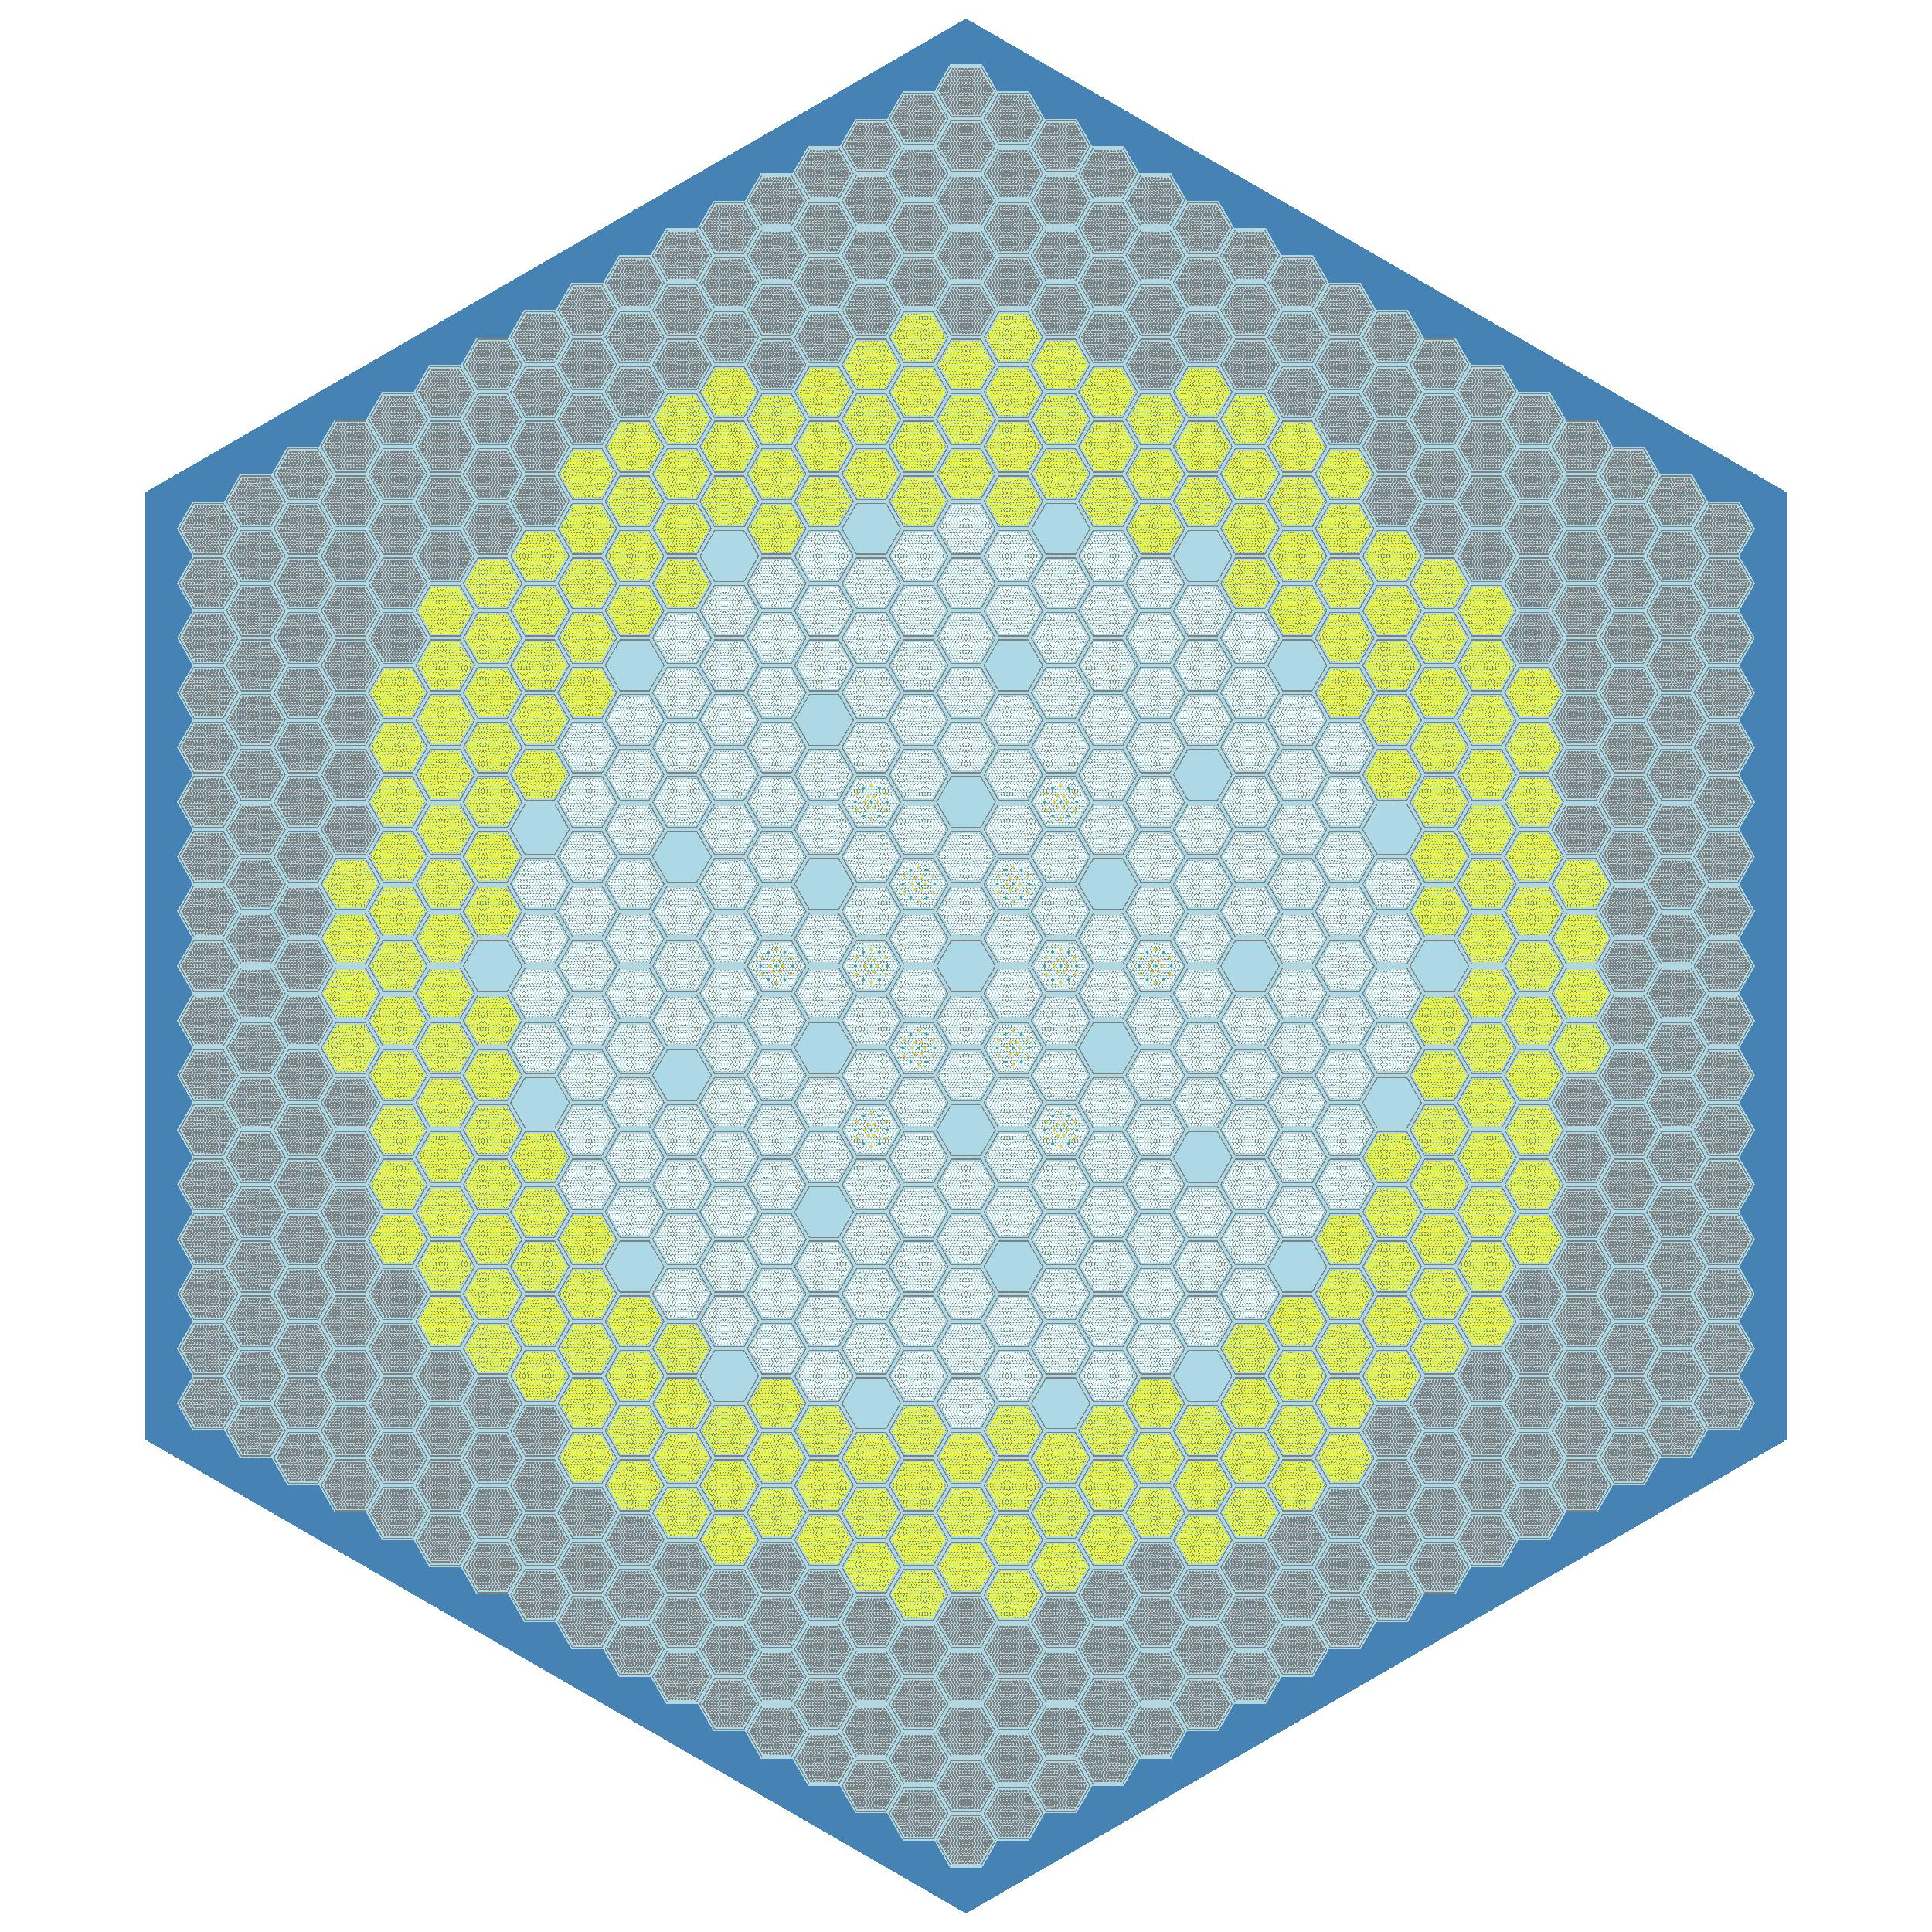

In [80]:
display(Image(filename=ruta + "/imagenes/sfr_core_full.jpg"))

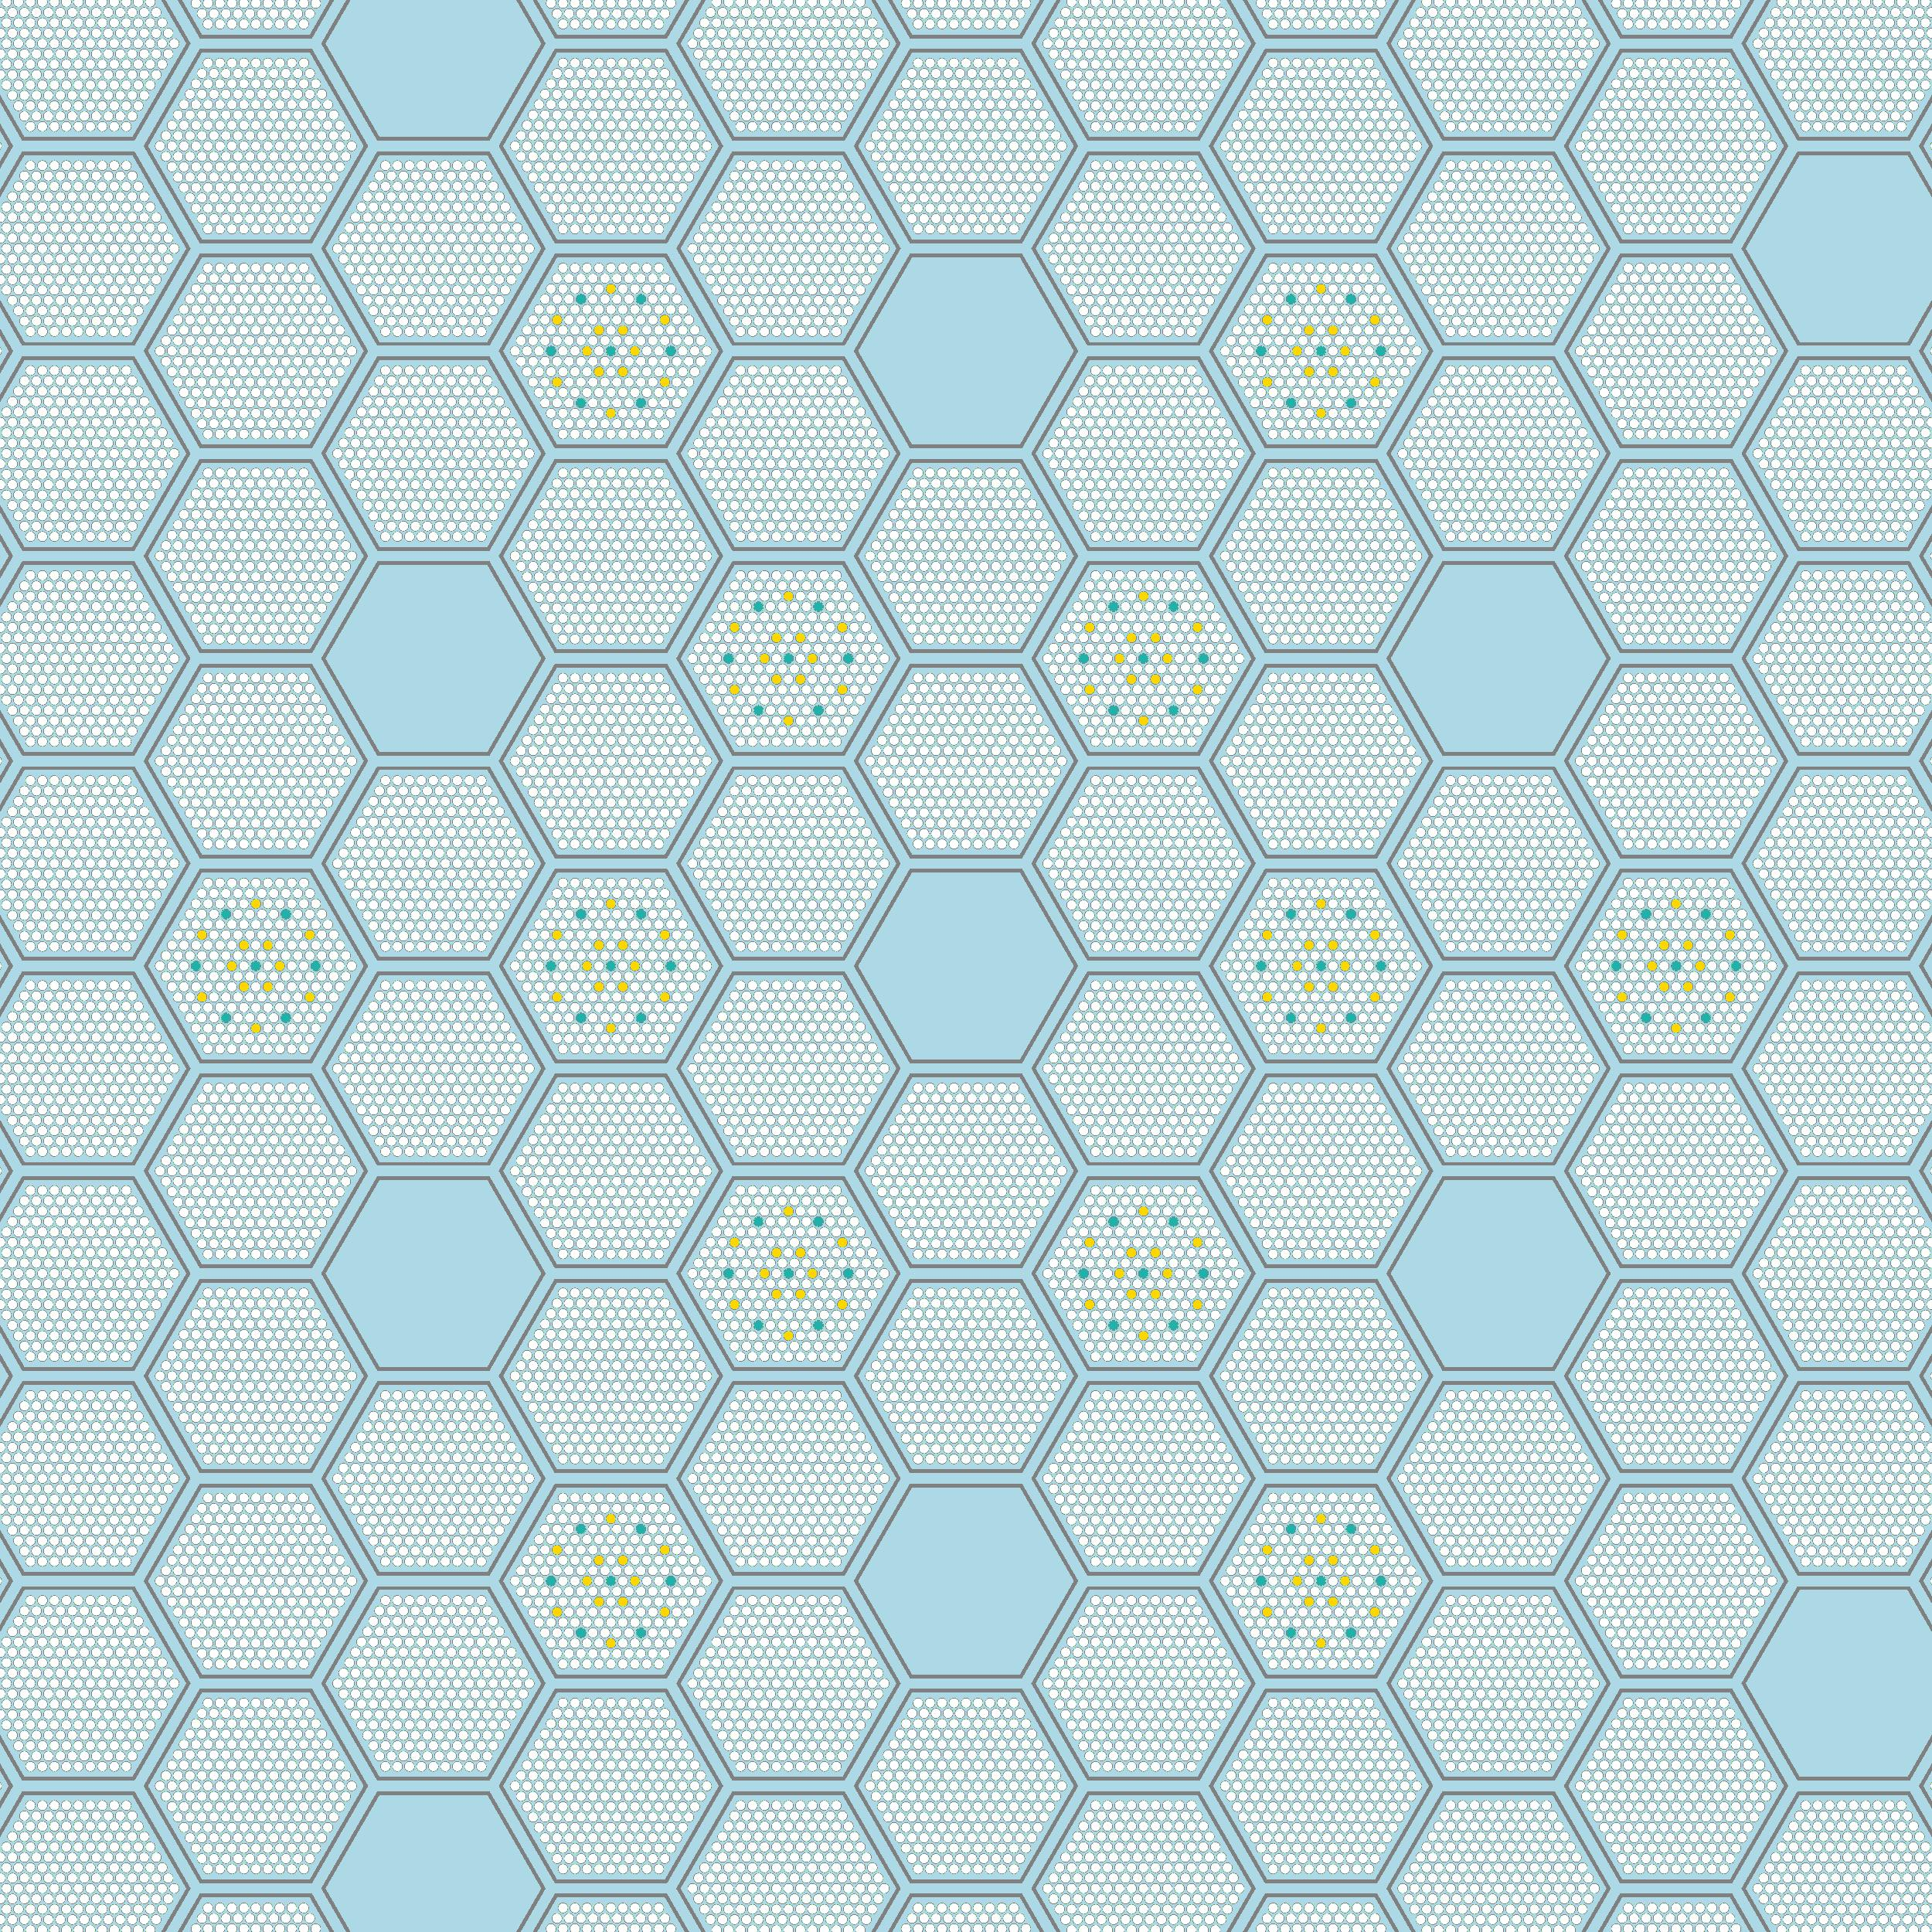

In [81]:
display(Image(filename=ruta + "/imagenes/sfr_core_detail.jpg"))

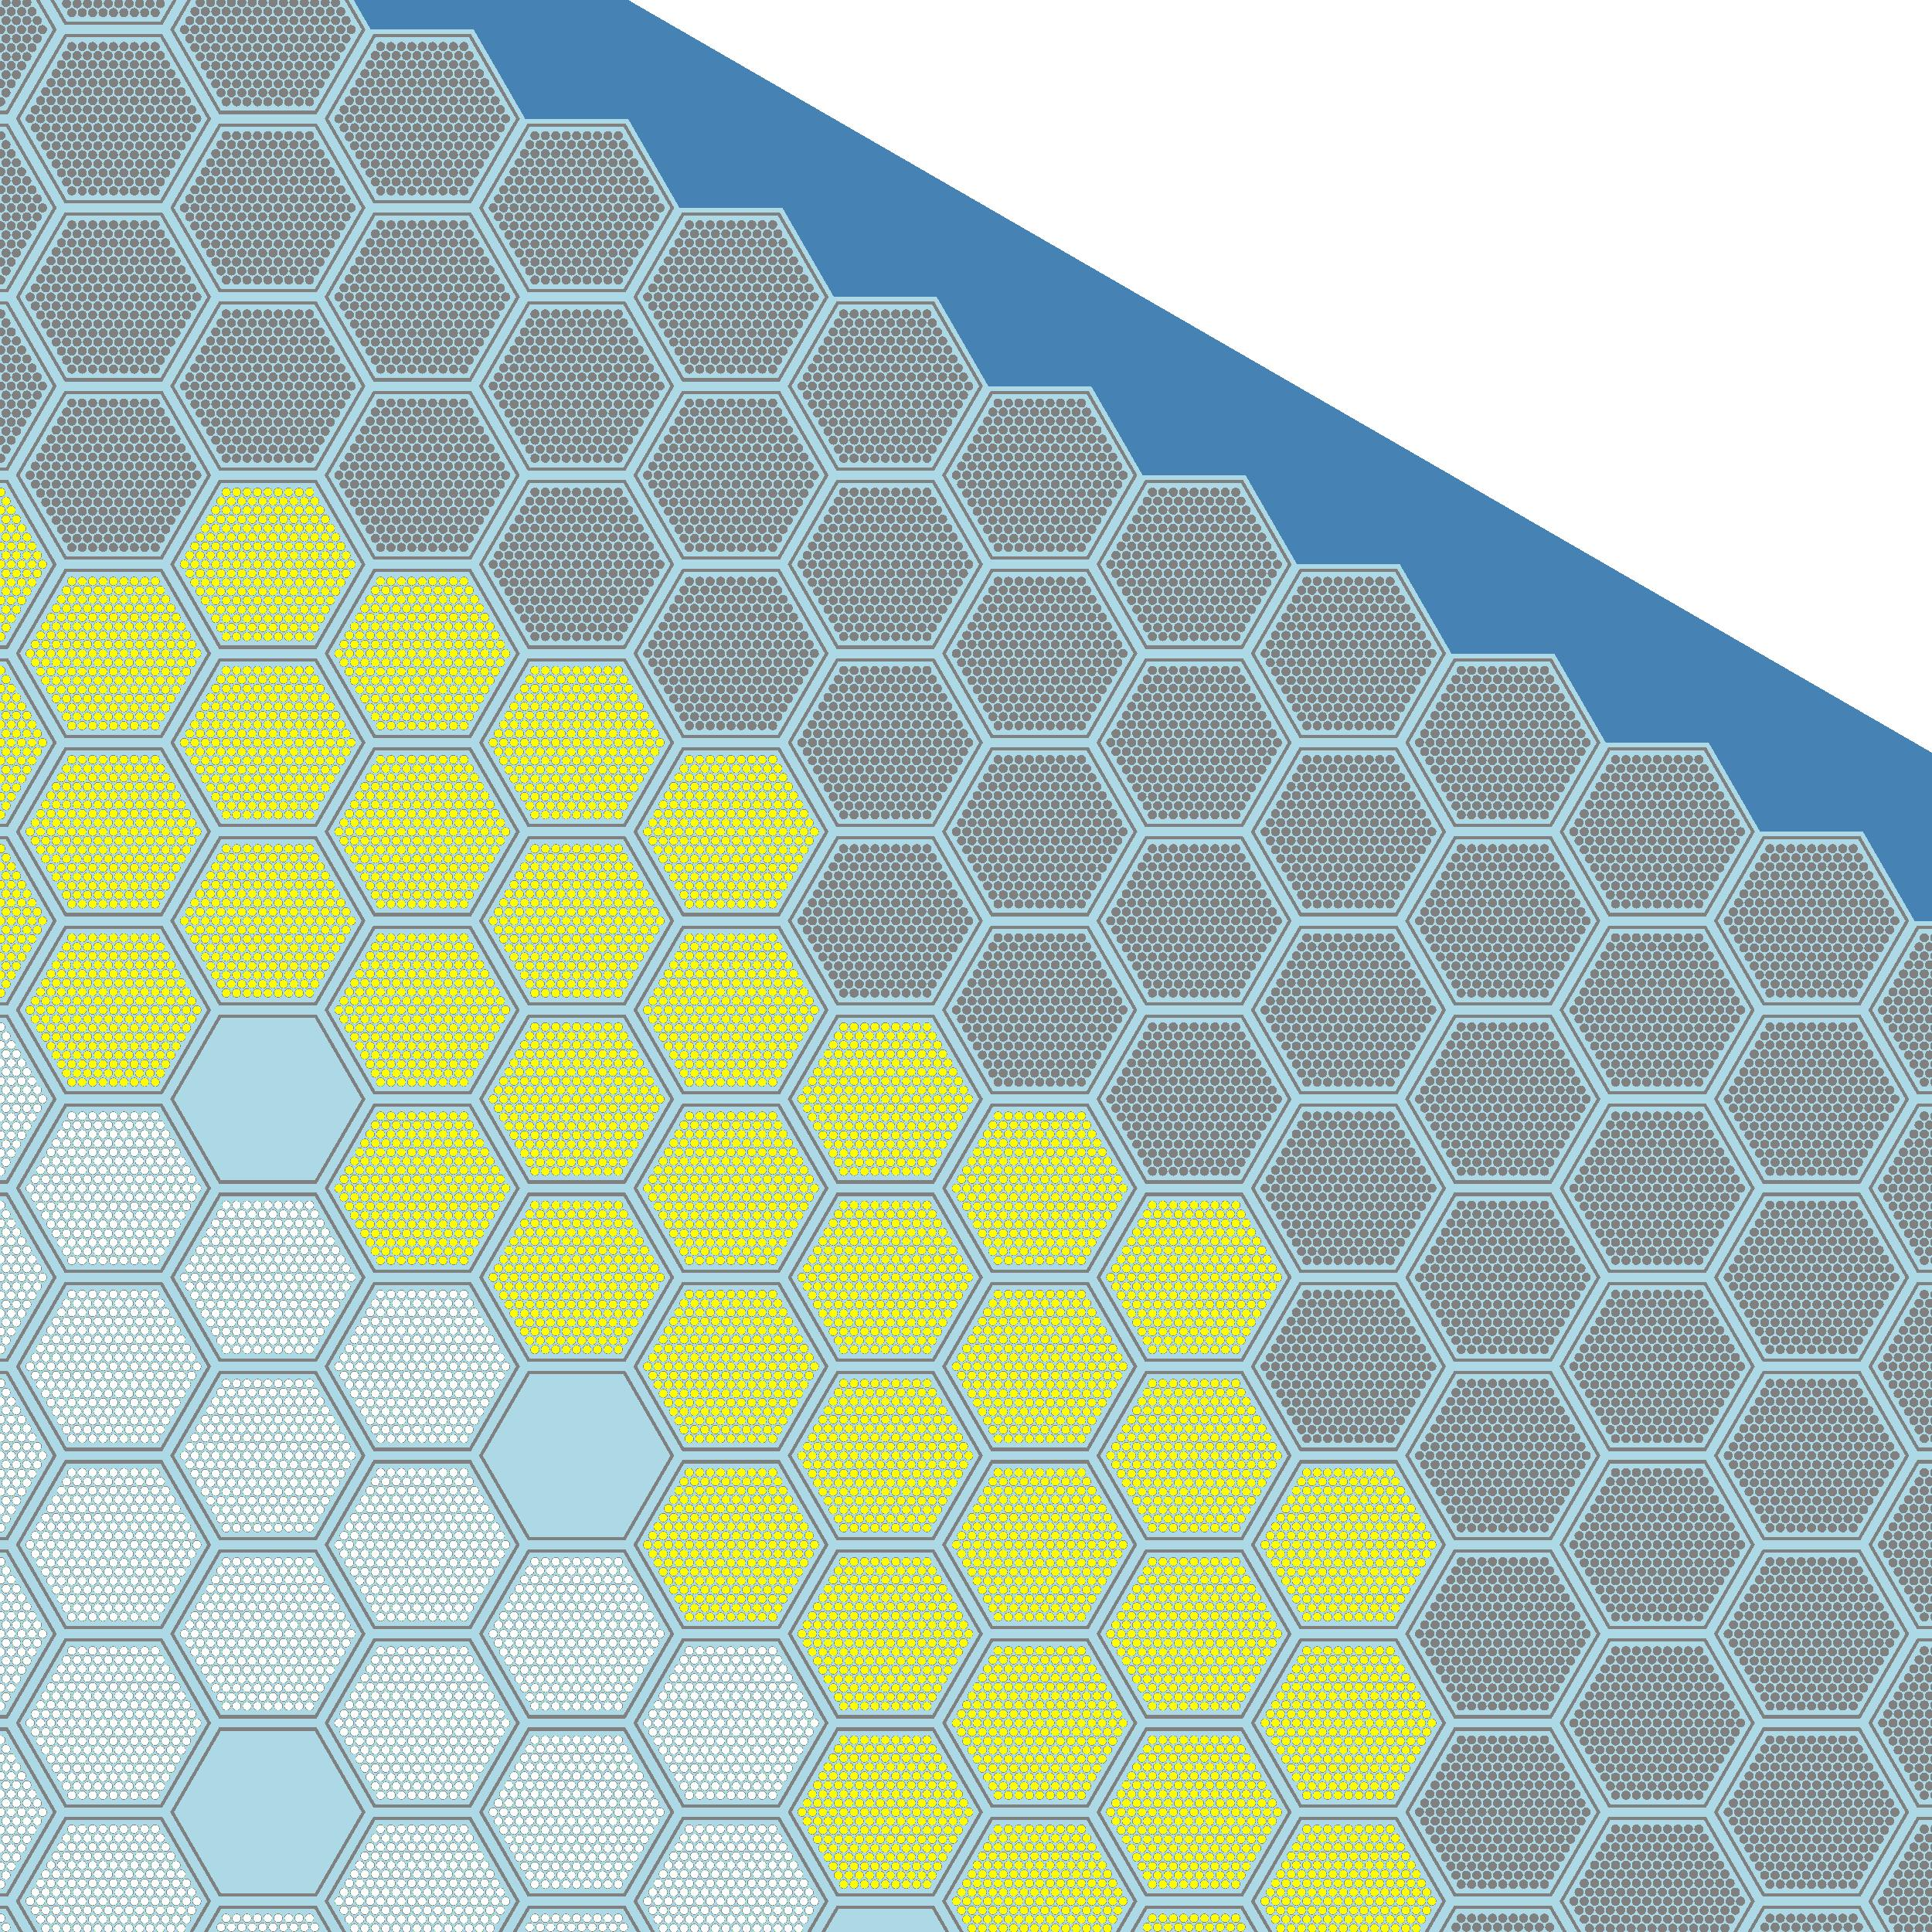

In [82]:
display(Image(filename=ruta + "/imagenes/sfr_core_allass.jpg"))

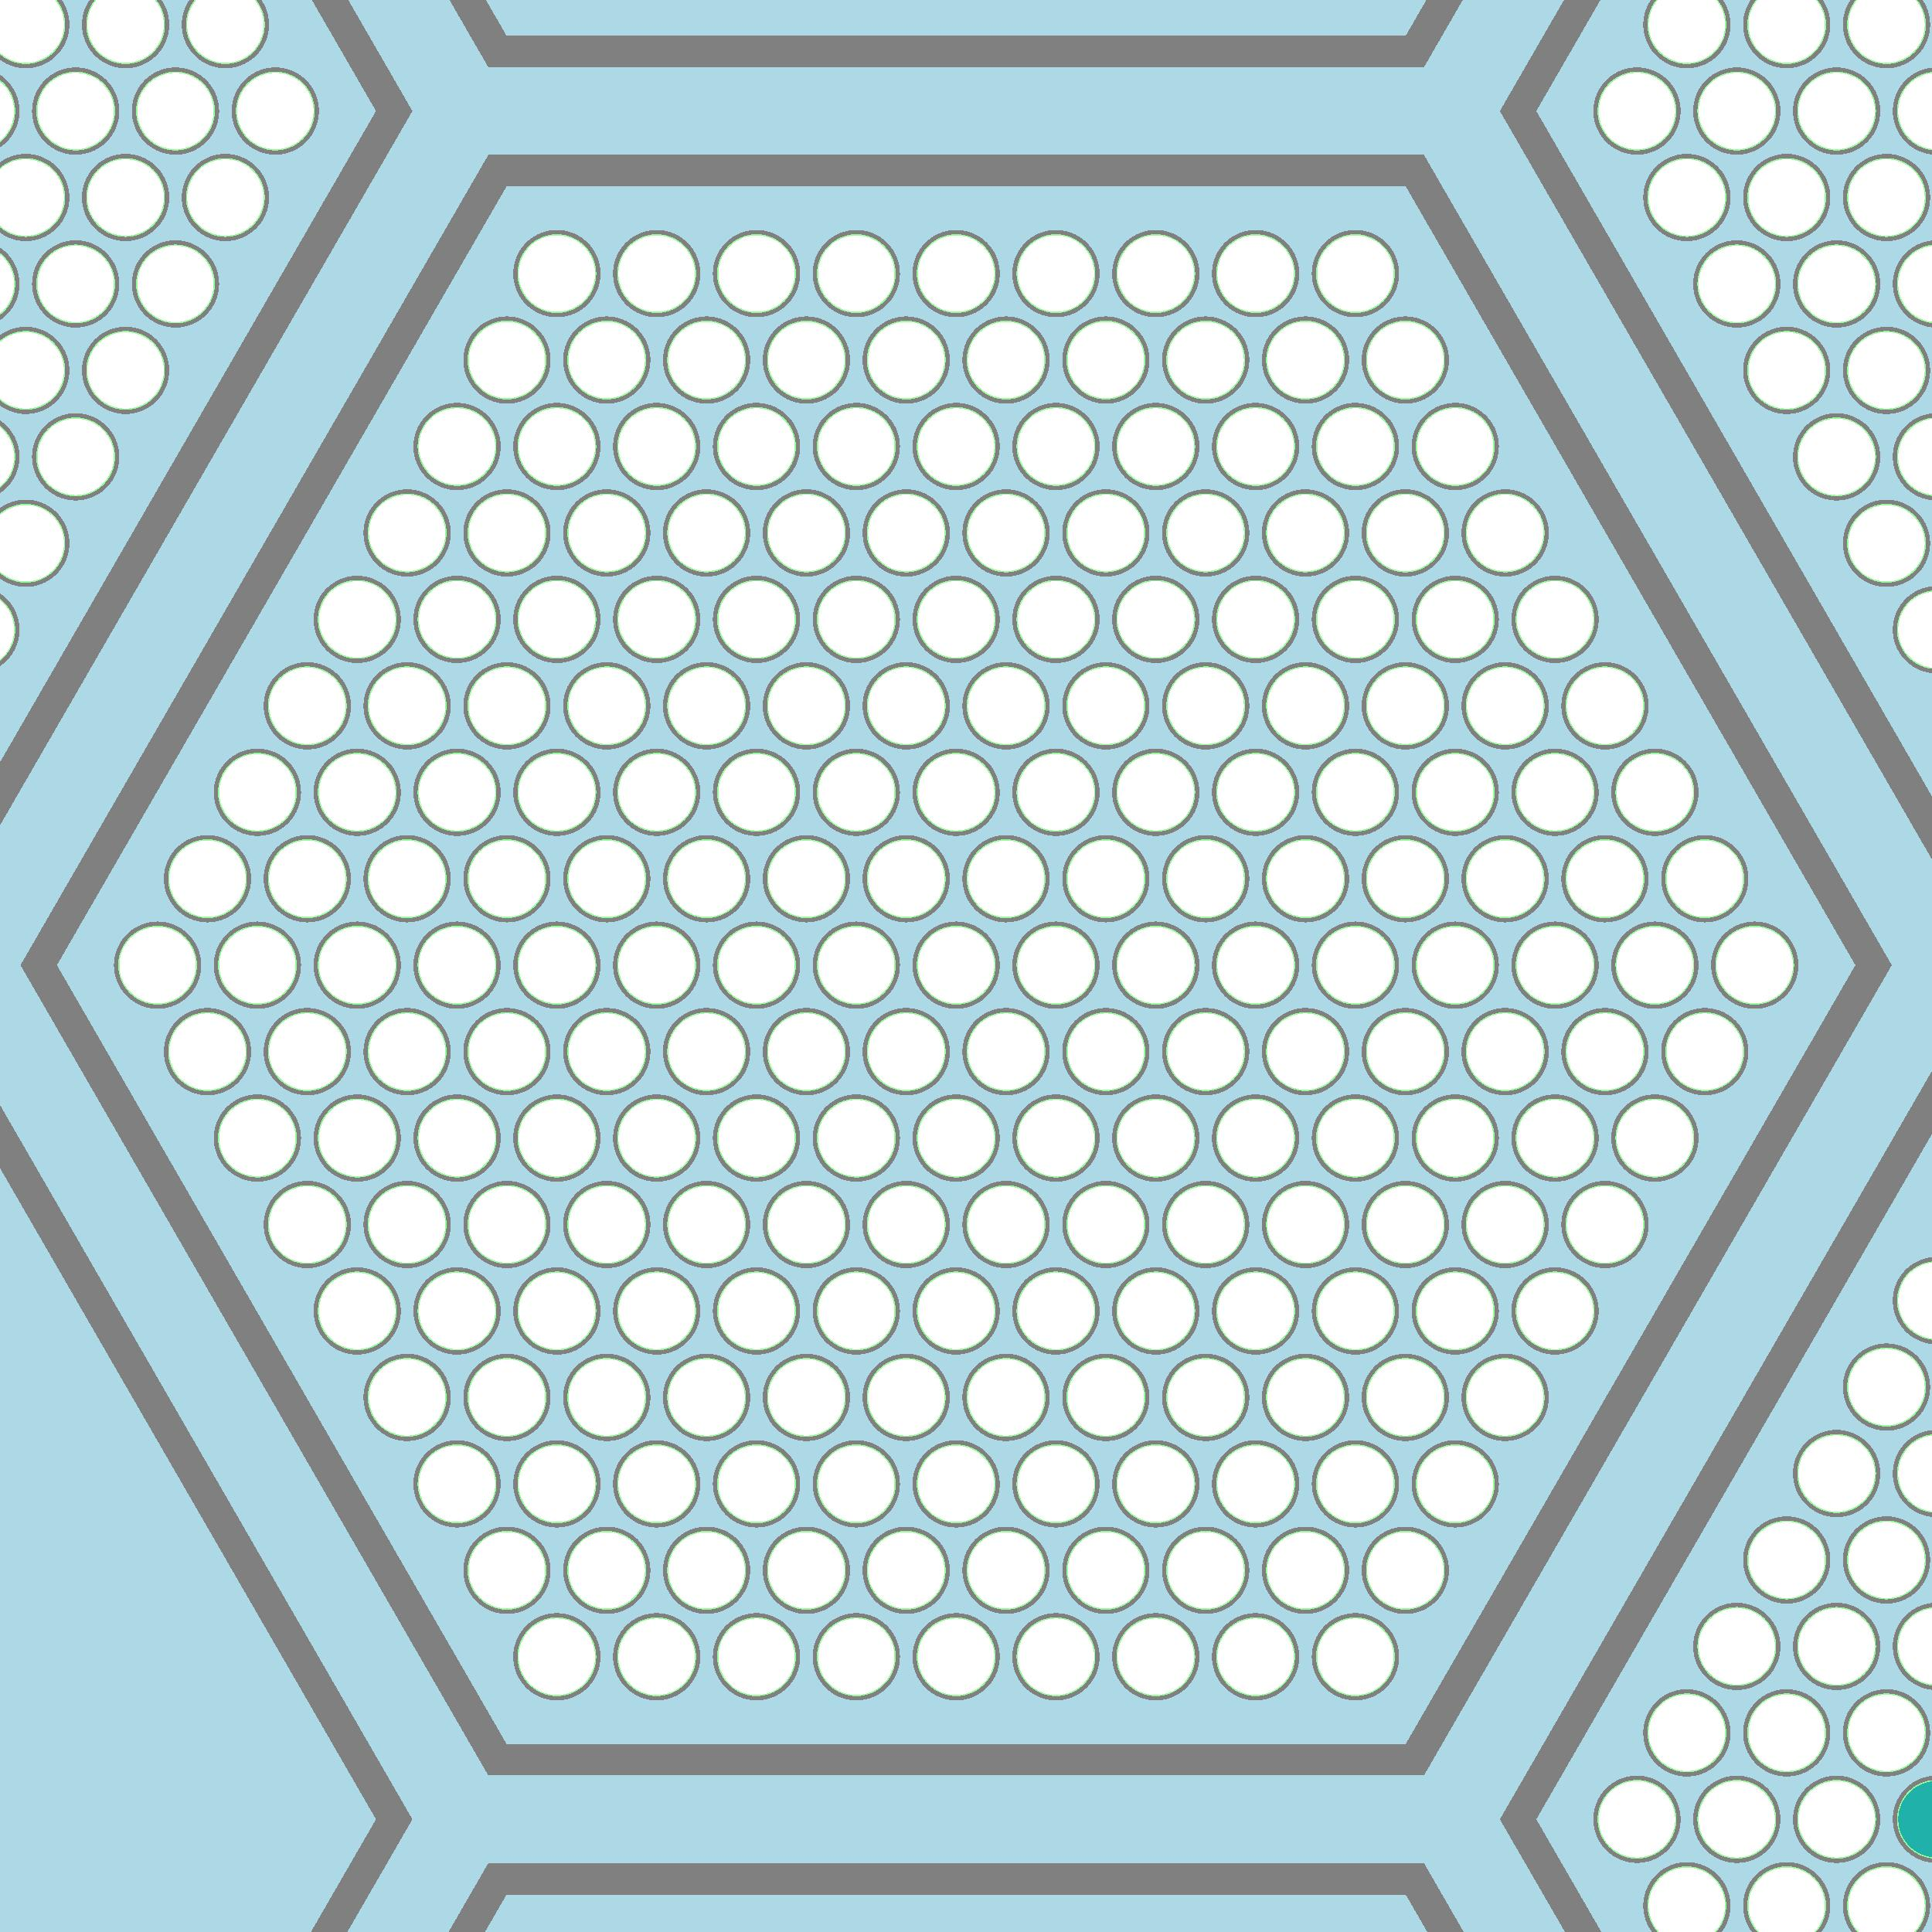

In [83]:
display(Image(filename=ruta + "/imagenes/sfr_assembly.jpg"))

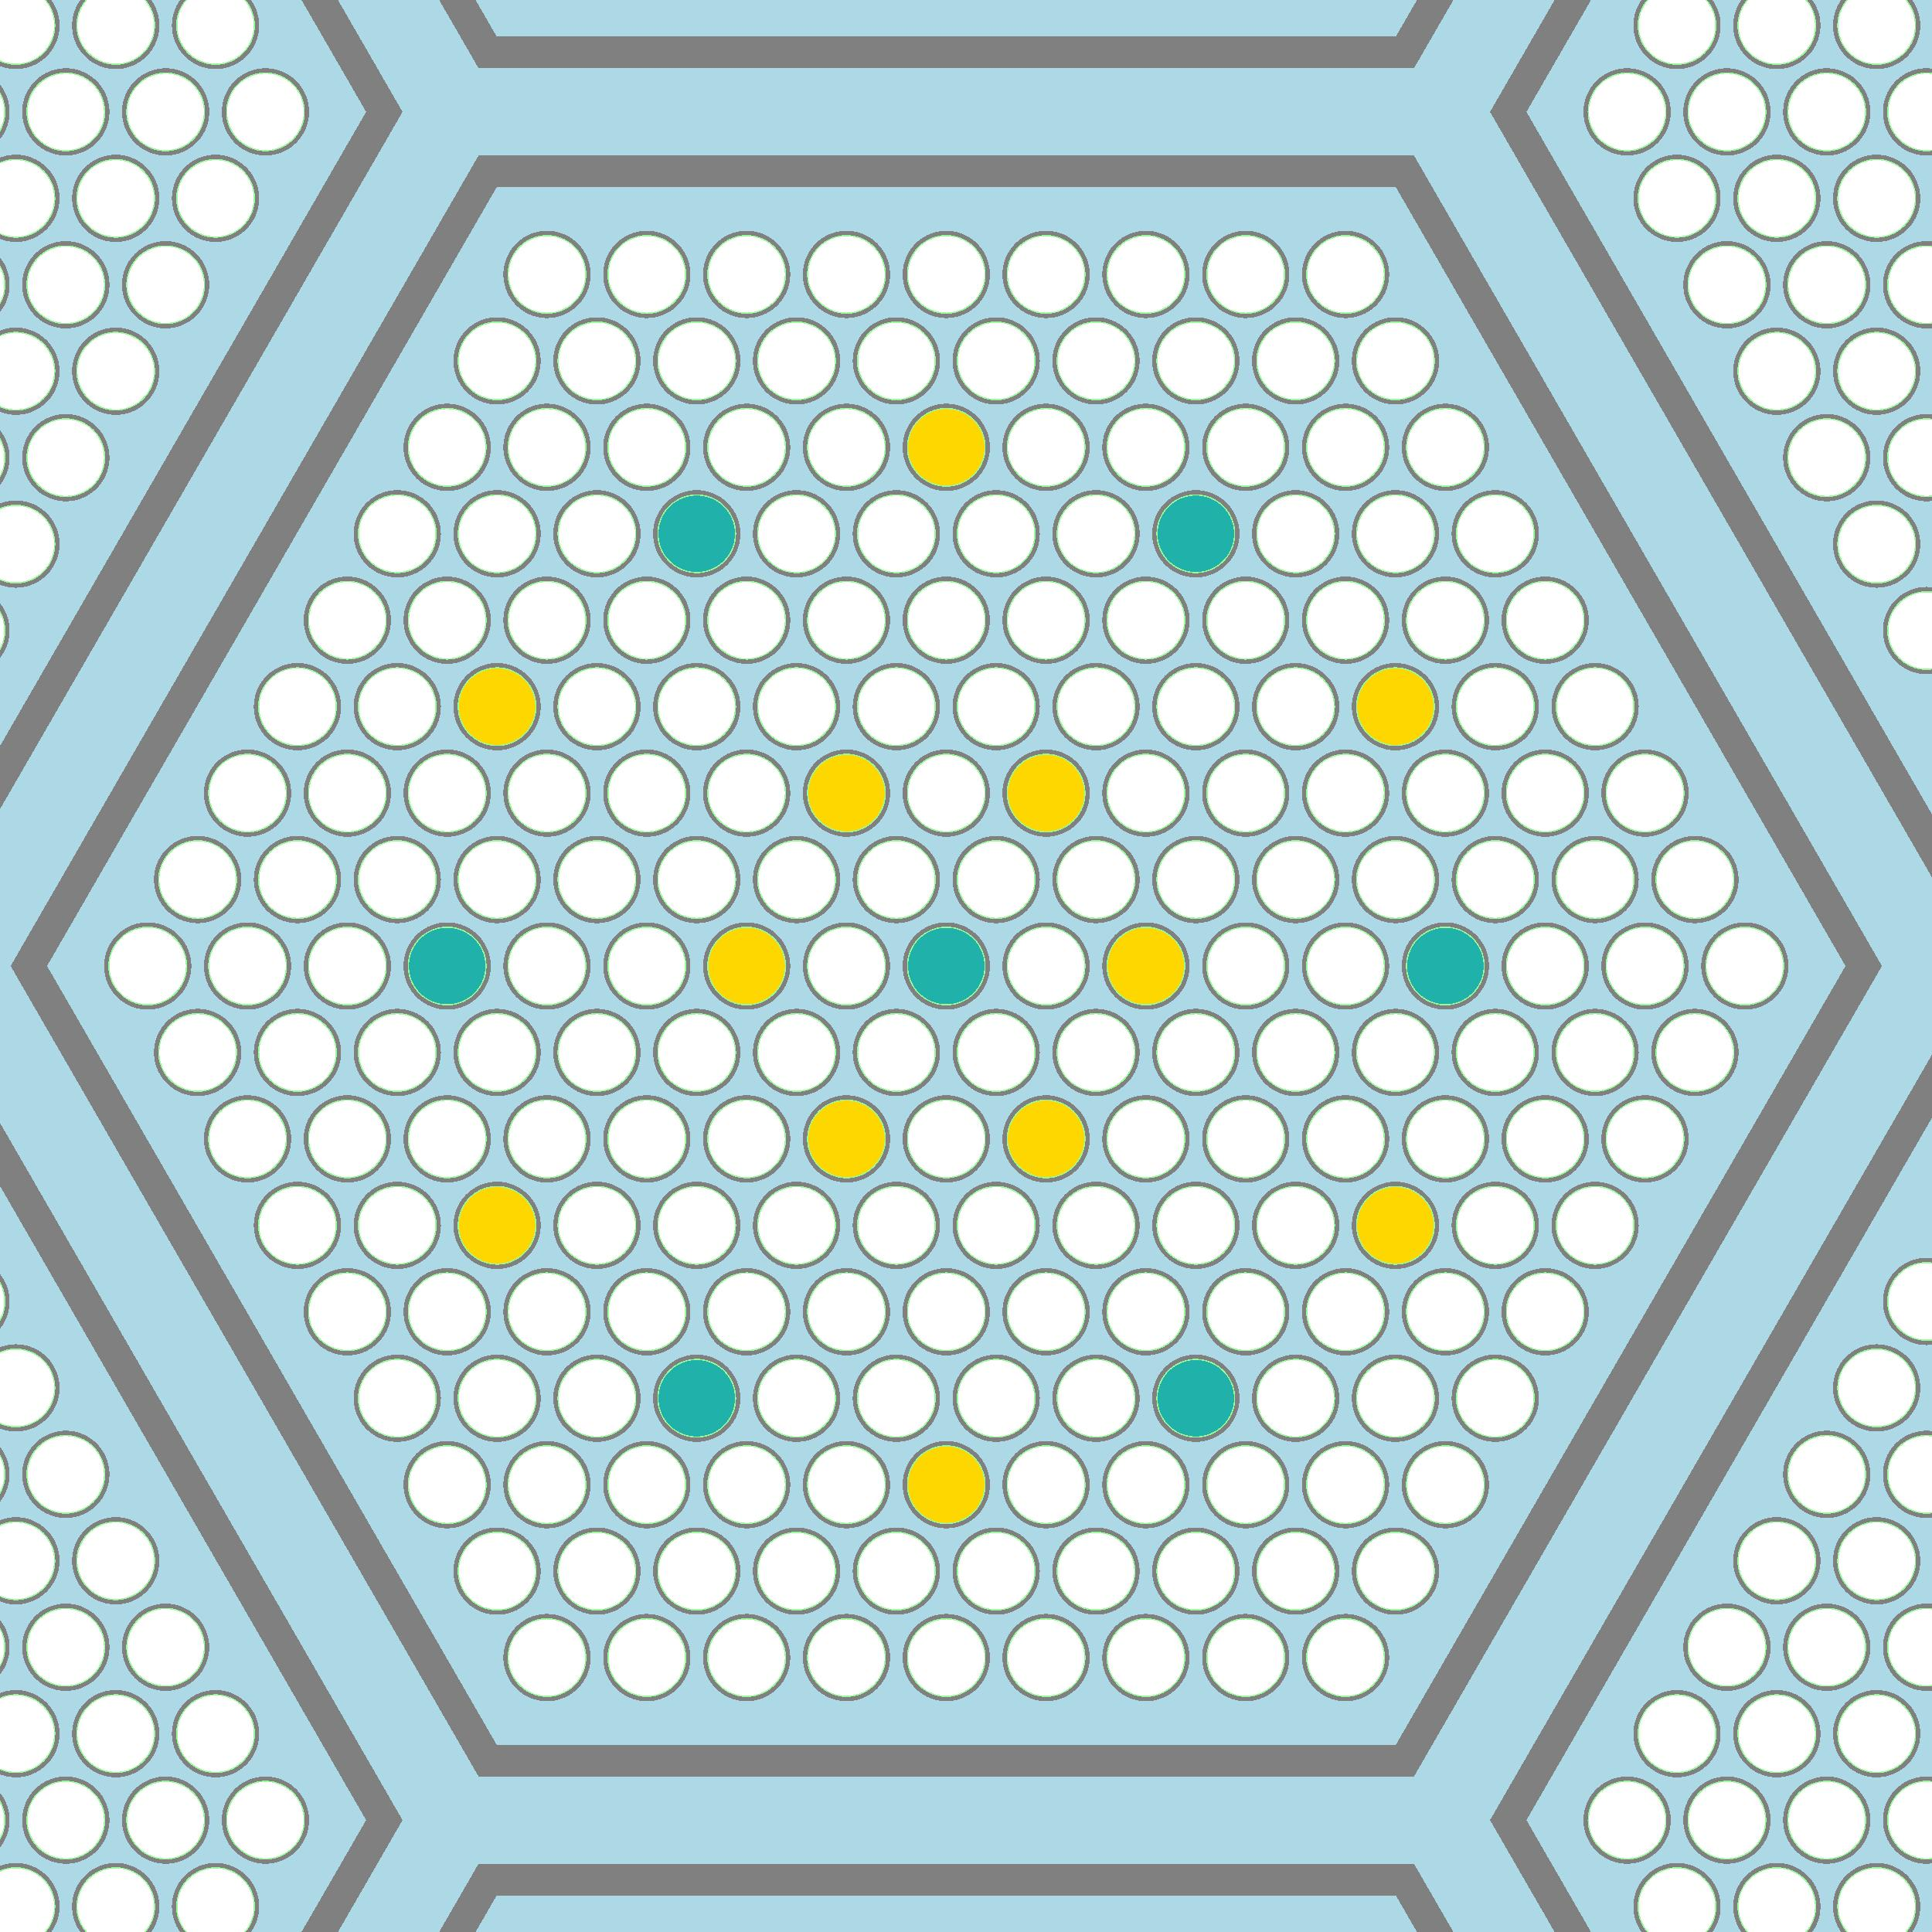

In [84]:
display(Image(filename=ruta + "/imagenes/sfr_assembly_fp.jpg"))

In [85]:
display(Image(filename=ruta + "/imagenes/sfr_fuelpin.jpg"))

FileNotFoundError: [Errno 2] No such file or directory: './build_01/imagenes/sfr_fuelpin.jpg'

## Run

Se ejecuta la simulación:

In [ ]:
# openmc.run()

En caso de fallo, se puede comprobar la geometría ejecutando:

In [ ]:
# openmc.run(geometry_debug=True)

## Depletion

**Cálculo de quemado de combustible**

Para poder llevar a cabo la simulación del Depletion, es necesario proporcionar el volumen total de combustible.<br>
Este es un paso clave en la simulación ya que afecta directamente al quemado del combustible.

In [ ]:
inner.volume = math.pi * (combustible_r) ** 2 * altura_nucleo * (217 * n_ec_interiores - ((n_varillas_tc99 + n_varillas_yi3) * n_ec_pf))

In [ ]:
outer.volume = math.pi * (combustible_r) ** 2 * altura_nucleo * 217 * n_ec_exteriores

In [ ]:
tc99.volume = math.pi * (combustible_r) ** 2 * altura_nucleo * n_varillas_tc99 * n_ec_pf

In [ ]:
yi3.volume = math.pi * (combustible_r) ** 2 * altura_nucleo * n_varillas_yi3 * n_ec_pf

La ejecución de la simulación se realiza mediante __*openmc.deplete*__

Es necesario aportar la cadena de desintegración, en este caso se usa la librería **ENDF/B-VII.1** para **espectro rápido**:

In [ ]:
chain = openmc.deplete.Chain.from_xml("./../../openmc/Cross_Section_Libraries/endfb71_hdf5/chain_endfb71_sfr.xml")

El primer paso es crear el *Operator* a partir de la geometría y la configuración (los materiales se leen automáticamente).

In [ ]:
model = openmc.Model(geometry=geometry, settings=settings)
operator = openmc.deplete.CoupledOperator(model, "./../../openmc/Cross_Section_Libraries/endfb71_hdf5/chain_endfb71_sfr.xml")

Se define el nombre de la carpeta en la que se almacenan los archivos generados durante la simulación

In [ ]:
operator.output_dir= ruta

Se define la potencia de la celda de combustible en *W*. Para un reactor de este tipo, se definen 1000 MWe

In [ ]:
power = 1200e6

Se definen los pasos de la simulación, en este caso se va a simular el reactor en pasos de 30 días y durante 4 años y medio (54 meses)

In [ ]:
n_pasos = 30

In [ ]:
n_repeticion_pasos = 54

In [ ]:
time_steps = [n_pasos] * n_repeticion_pasos

Se ejecuta la simulación:

In [ ]:
integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d')

In [ ]:
integrator.integrate()

## Resultados

In [ ]:
# !cat tallies.out

### 0 - Importación de resultados desde el archivo

Se importan los resultados desde el archivo creado.

In [ ]:
results = openmc.deplete.Results(ruta + "/depletion_results.h5")

Se obtiene la *k efectiva*.

In [ ]:
time, k = results.get_keff()

Se convierten las unidades de tiempo (de segundos a días).

In [ ]:
time /= (24 * 60 * 60)

In [ ]:
inner_ID = "15"
outer_ID = "16"
tc99_ID = "7"
yi3_ID = "8"

In [ ]:
inner_ID = "16"
outer_ID = "17"
tc99_ID = "7"
yi3_ID = "8"

### 1 - Resultados generales

In [ ]:
pyplot.errorbar(time, k[:, 0], yerr=k[:, 1])
pyplot.ylim(0.98, 1.02)
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("$k_{eff}\pm \sigma$");

In [ ]:
_, u235_fission1 = results.get_reaction_rate(inner_ID, "U235", "fission")
_, u235_fission2 = results.get_reaction_rate(outer_ID, "U235", "fission")
_, u238_fission1 = results.get_reaction_rate(inner_ID, "U238", "fission")
_, u238_fission2 = results.get_reaction_rate(outer_ID, "U238", "fission")
_, pu239_fission1 = results.get_reaction_rate(inner_ID, "Pu239", "fission")
_, pu239_fission2 = results.get_reaction_rate(outer_ID, "Pu239", "fission")
_, pu240_fission1 = results.get_reaction_rate(inner_ID, "Pu240", "fission")
_, pu240_fission2 = results.get_reaction_rate(outer_ID, "Pu240", "fission")
_, pu241_fission1 = results.get_reaction_rate(inner_ID, "Pu241", "fission")
_, pu241_fission2 = results.get_reaction_rate(outer_ID, "Pu241", "fission")

t_fission235 = u235_fission1 + u235_fission2
t_fission238 = u238_fission1 + u238_fission2
t_fission239 = pu239_fission1 + pu239_fission2
t_fission240 = pu240_fission1 + pu240_fission2
t_fission241 = pu241_fission1 + pu241_fission2

In [ ]:
pyplot.plot(time, u235_fission1, label = "U235")
pyplot.plot(time, u238_fission1, label = "U238")
pyplot.plot(time, pu239_fission1, label = "Pu239")
pyplot.plot(time, pu240_fission1, label = "Pu240")
pyplot.plot(time, pu241_fission1, label = "Pu241")
pyplot.xlabel("Tiempo [d]")
pyplot.ylabel("Fisiones / s");
pyplot.legend(loc="upper right")
pyplot.show()

In [ ]:
pyplot.plot(time, u235_fission2, label = "U235")
pyplot.plot(time, u238_fission2, label = "U238")
pyplot.plot(time, pu239_fission2, label = "Pu239")
pyplot.plot(time, pu240_fission2, label = "Pu240")
pyplot.plot(time, pu241_fission2, label = "Pu241")
pyplot.xlabel("Tiempo [d]")
pyplot.ylabel("Fisiones / s");
pyplot.legend(loc="upper right")
pyplot.show()

In [ ]:
pyplot.plot(time, t_fission235, label = "U235")
pyplot.plot(time, t_fission238, label = "U238")
pyplot.plot(time, t_fission239, label = "Pu239")
pyplot.plot(time, t_fission240, label = "Pu240")
pyplot.plot(time, t_fission241, label = "Pu241")
pyplot.xlabel("Tiempo [d]")
pyplot.ylabel("Fisiones / s");
pyplot.legend(loc="upper right")
pyplot.show()

In [ ]:
_, xe135_1 = results.get_atoms(inner_ID, "Xe135")
_, xe135_2 = results.get_atoms(outer_ID, "Xe135")
xe135 = xe135_1 + xe135_2

In [ ]:
pyplot.plot(time, xe135, label="Xe135")
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("Número de átomos - Xe135");

### 2 - Resultados por nucleido

#### U235

In [ ]:
# Se obtienen las masas de cada material (tipo de combustible) y se suman
_, m_u235_1 = results.get_mass(inner_ID, "U235")
_, m_u235_2 = results.get_mass(outer_ID, "U235")
m_u235 = m_u235_1 + m_u235_2

# Se calcula la producción de U235 en toneladas (en este caso, saldrá negativa ya que se consume)
p_u235 = (m_u235[n_repeticion_pasos] - m_u235[0])/1000
p_u235 # kg

In [ ]:
pyplot.plot(time, m_u235/1000, label="Total")
pyplot.plot(time, m_u235_1/1000, label="Mt1")
pyplot.plot(time, m_u235_2/1000, label="Mt2")
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("Masa (kg) - U235")
pyplot.legend(loc="upper right")
pyplot.show()

#### U238

In [ ]:
_, m_u238_1 = results.get_mass(inner_ID, "U238")
_, m_u238_2 = results.get_mass(outer_ID, "U238")
m_u238 = m_u238_1 + m_u238_2

# Se calcula la producción de U238 en toneladas (en este caso, saldrá negativa ya que se consume)
p_u238 = (m_u238[n_repeticion_pasos] - m_u238[0])/1000
p_u238 # kg

In [ ]:
pyplot.plot(time, m_u238, label="U238")
pyplot.xlabel("Tiempo [d]")
pyplot.ylabel("Masa (g)");

#### Pu

In [ ]:
_, m_pu238_1 = results.get_mass(inner_ID, "Pu238")
_, m_pu238_2 = results.get_mass(outer_ID, "Pu238")
m_pu238 = m_pu238_1 + m_pu238_2
p_pu238 = (m_pu238[n_repeticion_pasos] - m_pu238[0])/1000
p_pu238 # kg

In [ ]:
_, m_pu239_1 = results.get_mass(inner_ID, "Pu239")
_, m_pu239_2 = results.get_mass(outer_ID, "Pu239")
m_pu239 = m_pu239_1 + m_pu239_2
p_pu239 = (m_pu239[n_repeticion_pasos] - m_pu239[0])/1000
p_pu239 # kg

In [ ]:
_, m_pu240_1 = results.get_mass(inner_ID, "Pu240")
_, m_pu240_2 = results.get_mass(outer_ID, "Pu240")
m_pu240 = m_pu240_1 + m_pu240_2
p_pu240 = (m_pu240[n_repeticion_pasos] - m_pu240[0])/1000
p_pu240 # kg

In [ ]:
_, m_pu241_1 = results.get_mass(inner_ID, "Pu241")
_, m_pu241_2 = results.get_mass(outer_ID, "Pu241")
m_pu241 = m_pu241_1 + m_pu241_2
p_pu241 = (m_pu241[n_repeticion_pasos] - m_pu241[0])/1000
p_pu241 #kg

In [ ]:
_, m_pu242_1 = results.get_mass(inner_ID, "Pu242")
_, m_pu242_2 = results.get_mass(outer_ID, "Pu242")
m_pu242 = m_pu242_1 + m_pu242_2
p_pu242 = (m_pu242[n_repeticion_pasos] - m_pu242[0])/1000
p_pu242 #kg

In [ ]:
pyplot.plot(time, m_pu238/1000, label="Pu238")
pyplot.plot(time, m_pu239/1000, label="Pu239")
pyplot.plot(time, m_pu240/1000, label="Pu240")
pyplot.plot(time, m_pu241/1000, label="Pu241")
pyplot.plot(time, m_pu242/1000, label="Pu242")
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("Masa (kg)")
pyplot.legend(loc="upper left")
pyplot.show()

#### Np

In [ ]:
_, m_np237_1 = results.get_mass(inner_ID, "Np237")
_, m_np237_2 = results.get_mass(outer_ID, "Np237")
m_np237 = m_np237_1 + m_np237_2
p_np237 = (m_np237[n_repeticion_pasos] - m_np237[0])/1000
p_np237 # kg

In [ ]:
pyplot.plot(time, m_np237/1000, label="Np237")
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("Masa (kg)");

#### Am

In [ ]:
_, m_am241_1 = results.get_mass(inner_ID, "Am241")
_, m_am241_2 = results.get_mass(outer_ID, "Am241")
m_am241 = m_am241_1 + m_am241_2
p_am241 = (m_am241[n_repeticion_pasos] - m_am241[0])/1000
p_am241 #kg

In [ ]:
_, m_am243_1 = results.get_mass(inner_ID, "Am243")
_, m_am243_2 = results.get_mass(outer_ID, "Am243")
m_am243 = m_am243_1 + m_am243_2
p_am243 = (m_am243[n_repeticion_pasos] - m_am243[0])/1000
p_am243 # kg

In [ ]:
pyplot.plot(time, m_am241/1000, label="Am241")
pyplot.plot(time, m_am243/1000, label="Am243")
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("Masa (kg)")
pyplot.legend(loc="upper right")
pyplot.show()

#### Cm

In [ ]:
_, m_cm244_1 = results.get_mass(inner_ID, "Cm244")
_, m_cm244_2 = results.get_mass(outer_ID, "Cm244")
m_cm244 = m_cm244_1 + m_cm244_2
p_cm244 = m_cm244[n_repeticion_pasos] - m_cm244[0]
p_cm244

In [ ]:
_, m_cm245_1 = results.get_mass(inner_ID, "Cm245")
_, m_cm245_2 = results.get_mass(outer_ID, "Cm245")
m_cm245 = m_cm245_1 + m_cm245_2
p_cm245 = m_cm245[n_repeticion_pasos] - m_cm245[0]
p_cm245

In [ ]:
pyplot.plot(time, m_cm244/1000, label="Cm244")
pyplot.plot(time, m_cm245/1000, label="Cm245")
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("Masa (kg)")
pyplot.legend(loc="upper right")
pyplot.show()

#### Tc-99

In [ ]:
_, m_tc99 = results.get_mass(tc99_ID, "Tc99")
p_tc99 = m_tc99[n_repeticion_pasos] - m_tc99[0]
p_tc99

In [ ]:
pyplot.plot(time, m_tc99/1000, label="Tc-99")
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("Masa (kg)")
pyplot.legend(loc="upper right")
pyplot.show()

#### I-129

In [ ]:
_, m_i129 = results.get_mass(yi3_ID, "I129")
p_i129 = m_i129[n_repeticion_pasos] - m_i129[0]
p_i129

In [ ]:
pyplot.plot(time, m_i129/1000, label="I-129")
pyplot.xlabel("Tiempo [días]")
pyplot.ylabel("Masa (kg)")
pyplot.legend(loc="upper right")
pyplot.show()